In [1]:
suppressPackageStartupMessages(library(dplyr)) 
library(ggplot2)
library(pheatmap)
library(repr)
library(RColorBrewer)
suppressPackageStartupMessages(library(ggalluvial))

library(Seurat)

source("/projects/ps-renlab2/y2xie/scripts/basics.R")
source("/projects/ps-renlab2/y2xie/scripts/DPT_help.R")

Warning message:
“package ‘pheatmap’ was built under R version 4.3.2”
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Warning message:
“package ‘dichromat’ was built under R version 4.3.2”
Loading required package: viridisLite


Attaching package: ‘viridis’


The following object is masked from ‘package:scales’:

    viridis_pal




In [2]:
suppressPackageStartupMessages(library("msigdbr"))
suppressPackageStartupMessages(library("fgsea"))

suppressPackageStartupMessages(library(GenomicRanges))
suppressPackageStartupMessages(library(enrichR))
dbs <- c("GO_Biological_Process_2021")

suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))

In [3]:
### annotate peaks
sum_detailed_anno <- function(df){
    t1 <- table(df$Detailed.Annotation) %>% as.data.frame %>%
    mutate(Var1 = gsub("^([^\\(]+).*", "\\1", Var1)) %>%
    group_by(Var1) %>% summarise(Freq = sum(Freq))

    t1a1 <- t1[grep("\\|", t1$Var1, invert = T), ] %>%
    mutate(Var1 = gsub("^(CpG)-.*$", "\\1", Var1)) %>%
    group_by(Var1) %>% summarise(Freq = sum(Freq)) %>% setNames(c("Var1", "Freq"))

    t1a2 <- t1[grep("\\|", t1$Var1), ] %>% 
    mutate(Var1 = gsub("^([^|]+)\\|([^|]+)\\|([^|]+)$", "\\2", Var1)) %>%
    mutate(Var1 = gsub("\\?", "", Var1)) %>%
    mutate(simple = ifelse(Var1 %in% c("LINE", "LTR", "SINE", "Simple_repeat"), Var1, "Other repeats")) %>%
    group_by(simple) %>% summarise(Freq = sum(Freq)) %>% setNames(c("Var1", "Freq"))

    anno <- rbind(t1a1, t1a2)
    return(anno)
}

In [12]:
### set cell tree
corder <- c('vCM','aCM','Epicardial','SM','Pericyte','Neuronal','Fibroblast',
            'Adipocyte','Endothelial','Endocardial','Myeloid','Lymphoid')

celltype_colors <- c(
    vCM = "#b94656",
    aCM = "#b95c38",
    Fibroblast = "#c0a13b",
    SM = "#71893b",
    Pericyte = "#6dbc5f",
    Epicardial = "#45c097",
    Endocardial = "#628ed6",
    Endothelial = "#6a70d7",
    Neuronal = "#5a3687",
    Myeloid = "#c074cc",
    Lymphoid = "#d16bad",
    Adipocyte = "#aa3d71"
)

cols1 <- c('#1F78B4', '#FB9A99'); names(cols1) <- c("M", "F")
cols2 <- c('#B2DF8A', '#FF7F00', '#CAB2D6'); names(cols2) <- c("CONTROL", "Ischemic", "Non-ischemic")
cols3 <- c('#B15928', '#FDBF6F'); names(cols3) <- c("TRUE", "FALSE")
cols4 <- c("#006934", "#2EA7E0", "#956134", "#036EB8"); names(cols4) <- c("Hi-C", "H3K27ac", "H3K27me3","ATAC")
cols5 <- c("#4f652f", "#d44f3a", "#5bac96", "#e6b8b3"); names(cols5) <- c("LV", "LA", "RV","RA")
cols <- c("#cd5c5c", "#c0c0c0", "#008000", "#ffc800", '#66cdaa')
names(cols) <- c("E1", "E2", "E3", "E4", "E5")

cols0 <- c('3\' UTR ' = "#6F4066",
           '5\' UTR ' = "#B78EA6",
           'CpG' = "#71818D",
           'Intergenic' = "#326680",
           'TTS ' = "#B0BEC5",
           'exon ' = "#527172",
           'intron ' = "#495347",
           'non-coding ' = "#73A085",
           'promoter-TSS ' = "#D0C185",
           'LINE' = "#ECBF6D",
           'LTR' = "#C56D48",
           'Other repeats' = "#C0A08D",
           'SINE' = "#B05857",
           'Simple_repeat' = "#701B28")

In [3]:
wdir <- "/projects//ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/"

### Check TSS enrichment of all library

Using sample as id variables



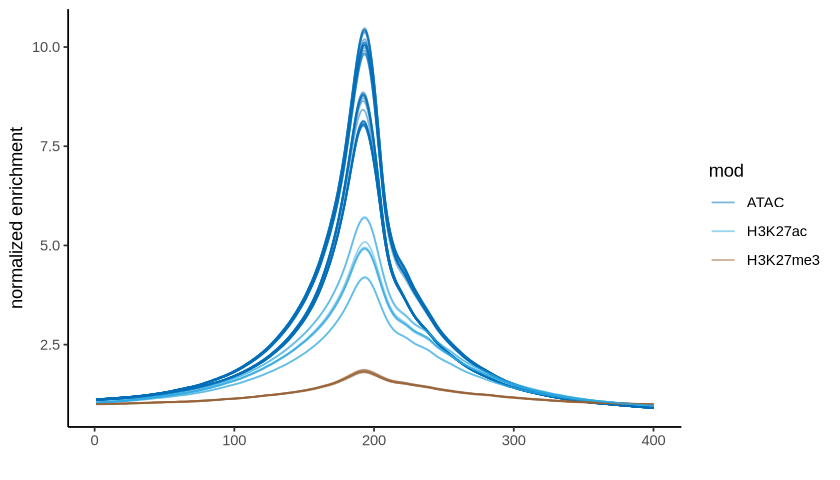

In [44]:
meta <- read.csv(paste0(wdir, "integration/All_data_int_metadata.file.txt"), sep = "\t")
lib1 <- meta %>% filter(orig.ident == "MULTIOME") %>% dplyr::select(library) %>% unlist %>% unique
lib2 <- meta %>% filter(Target == "H3K27ac") %>% dplyr::select(dna) %>% unlist %>% unique
lib3 <- meta %>% filter(Target == "H3K27me3") %>% dplyr::select(dna) %>% unlist %>% unique

enrichm <- read.csv(paste0(wdir, "06.bw/enrichment//FNIH_ATAC_DPT_TSSe_profile.txt"), sep = "\t", skip = 1, header = T, row.names = 1)
enrichm$X <- NULL
bdg <- enrichm[,c(1:3, 397:400)] %>% rowMeans
tmp <- (enrichm[,1:400]/bdg) %>% as.data.frame %>%
tibble::rownames_to_column('sample') %>%
reshape2::melt() %>%
mutate(variable = as.integer(gsub("X", "", variable))) 

t1 <- tmp %>% 
mutate(mod = ifelse(sample %in% paste0(lib1, "_rmdup"), "ATAC", "NA")) %>%
mutate(mod = ifelse(sample %in% paste0(lib2, "_rmdup"), "H3K27ac", mod)) %>%
mutate(mod = ifelse(sample %in% paste0(lib3, "_rmdup"), "H3K27me3", mod)) %>%
filter(mod != "NA") %>%
ggplot(aes(x = variable, y = value, color = mod, group = sample)) + 
geom_line(alpha = 0.5, linewidth = 0.5) + 
theme_classic() + xlab("") + ylab("normalized enrichment") + 
scale_color_manual(values = c("#036EB8", "#2EA7E0", "#956134"))

options(repr.plot.width = 7, repr.plot.height = 4)
t1

ggsave(t1, filename = "plot/FIG_ATAC_ac_me3_lib_normTSSe.pdf", dpi = 300, height = 4, width = 7)

### Visualize all ATAC cCREs

In [5]:
atac <- read.table(paste0(wdir, "reference/ATAC_celltype.cpm.txt"), header = T, row.names = 1)
k27ac <- read.csv(paste0(wdir, "05.R/FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cpm.csv"), header = T, row.names = 1)
k27me3 <- read.csv(paste0(wdir, "05.R/FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.cpm.csv"), header = T, row.names = 1)

dim(atac)

[1] 285873     12

In [ ]:
### How much of the genome covered?
tmp <- read.table(paste0(wdir, "reference/FNIH_peaks/Heart_UnionPeak.bed"))
sum(tmp$V3-tmp$V2)/2913022398 ### hg38

In [8]:
### read order: from NMF
tmp <- read.table(paste0(wdir, "reference/FNIH_peaks/NMF/res/FNIH_Heart_pool.ATAC_celltype.HeartUnionPeaks.r11n10.statW"), skip = 1)
tmp$V1 <- sub("-", ":", tmp$V1)
table(tmp$V3)


    0     1     2     3     4     5     6     7     8     9    10 
11910 12459 74915 20316 20966 31545 20879 39208 21079 27311  5285 

In [10]:
eorder <- tmp %>% mutate(V3 = factor(V3, levels = c(0,2,6,9,4,8,7,3,10,5,1))) %>%# filter(V1 %in% share) %>% 
arrange(V3) %>% dplyr::select(V1) %>% unlist

gapr <- tmp %>% mutate(V3 = factor(V3, levels = c(0,2,6,9,4,8,7,3,10,5,1))) %>%# filter(V1 %in% share) %>% 
arrange(V3) %>% dplyr::select(V3) %>% table %>% cumsum %>% unlist

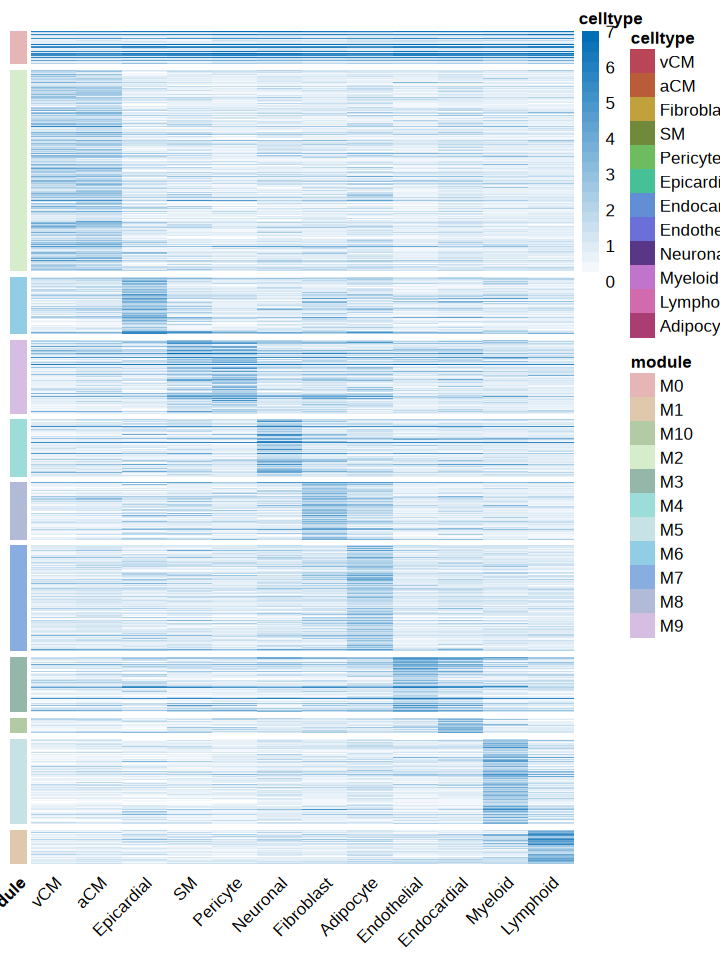

In [18]:
options(repr.plot.width = 6, repr.plot.height = 8)

rmat <- log2(atac[sub(":", "-", eorder), corder] + 1)
smat <- rmat #[permutation_vector, ]
smat[smat > 7] <- 7

ranno <- tmp %>% tibble::column_to_rownames("V1") %>% mutate(module = paste0("M", V3)) %>% dplyr::select(module)
rownames(ranno) <- sub(":", "-", rownames(ranno))
colsn <- c("#e6b5b5",
"#dfc8ab",
"#b3cba5",
"#d6edcc",
"#94b7a9",
"#9dddd9",
"#c6e2e4",
"#91cee5",
"#88aee1",
"#b1bbd7",
"#d6bee2")
names(colsn) <- sort(unique(ranno$module))

canno <- tmp %>% tibble::column_to_rownames("V1") %>% mutate(celltype = rownames(.)) %>% dplyr::select(celltype)
ccolor <- list(celltype = c(celltype_colors),
               module = colsn)

t1 <- smat %>%
pheatmap(scale = "none",cluster_rows = F, cluster_cols = F, angle_col = 45,
         annotation_colors = ccolor, gaps_row = gapr,
         show_rownames = F, annotation_row = ranno, 
         annotation_col = canno,
         border_color = NA, color = colorRampPalette(c("white", "#036EB8"))(25))

### Compare to SCREEN and HEA

In [15]:
suppressPackageStartupMessages(library(GenomicRanges))
screend <- read.table("/projects//ps-renlab2/y2xie/projects/genome_ref/SCREEN/GRCh38-cCREs.bed")
scsrange <- GRanges(screend$V1, ranges = IRanges(as.numeric(screend$V2), as.numeric(screend$V3)))

hed <- read.csv("/projects//ps-renlab2/y2xie/projects/public_data/Zhang2021_HumanAtlas/cCRE_hg38.tsv.gz", sep = '\t') %>% 
mutate(range = paste0(X.Chromosome, "-", hg38_Start, "-", hg38_End))

tmp[,c("chrom", "start", "end")] <- stringr::str_split_fixed(tmp$V1, pattern = "[:-]", n = 3)
trange <- GRanges(tmp$chrom, ranges = IRanges(as.numeric(tmp$start), as.numeric(tmp$end)))

In [16]:
ctp <- readMM("/projects//ps-renlab2/y2xie/projects/public_data/Zhang2021_HumanAtlas/cCRE_by_cell_type/matrix.tsv.gz")
celltype <- read.table("/projects//ps-renlab2/y2xie/projects/public_data/Zhang2021_HumanAtlas/cCRE_by_cell_type/celltypes.txt.gz", sep = '\t')
peak <- read.table("/projects//ps-renlab2/y2xie/projects/public_data/Zhang2021_HumanAtlas/cCRE_by_cell_type/cCREs.bed.gz", sep = '\t') %>%
mutate(range = paste0(V1, "-", V2, "-", V3))
rownames(ctp) <- peak$range
colnames(ctp) <- celltype$V1

In [20]:
hemeta <- read.csv("/projects//ps-renlab2/y2xie/projects/public_data/Zhang2021_HumanAtlas/Cell_metadata.tsv.gz", sep = "\t")
ccount <- hemeta[grep('heart', hemeta$tissue), ]$cell.type %>% table %>% as.data.frame
qcelltype <- ccount %>% filter(Freq >= 20) %>% arrange(Freq) %>% dplyr::select('.') %>% unlist %>% as.character

qcelltype %>% length
intersect(qcelltype, colnames(ctp)) %>% length

[1] 79

[1] 26

In [21]:
unmatch <- c("Fetal Macrophage Placental", "Fetal Alveolar Cap Endo", 'Fetal Fibro General 1', 'Fetal Fibro General 2', 'Fetal Fibro General 3',
 'Fetal Fibro General 4', 'Fetal Fibro GI', 'Fetal Fibro Muscle 1', 'Nerve Stromal', 'Fibro Nerve', 'Fibro General', 'Luteal', 'Naive T', 
  'Fetal Metanephric', 'Pericyte General 1','Pericyte General 2','Pericyte General 3','Pericyte Muscularis','Pericyte General 4',
  'Fetal Mesothelial', 'Fetal Endothelial Placental', 'Fetal Endothelial General 3', 'Fetal Endothelial General 1',
  'Endothelial General 1', 'Endothelial Myocardial', 'Endothelial General 2', 'Endothelial General 3', 'Plasma B',
  'Fetal Hematopoeitic Stem', 'Vasc Sm Muscle 1', 'Vasc Sm Muscle 2', 'Macrophage General', 'Endocardial', 'Fetal Endocardial',
  'Fetal Macrophage General 1', 'Fetal Macrophage General 2', 'Fetal Macrophage General 3', 'Fetal Macrophage General 4',
  'Natural Killer T', 'Fetal Schwann General', 'Fetal Alveolar Epithelial 1', 'Lymphatic', 'Fetal Lymphatic', 'Mast', 'Mesothelial',
  'Schwann General','V Cardiomyocyte', 'A Cardiomyocyte', 'Fetal V Cardiomyocyte', 'Fetal A Cardiomyocyte', 'Cardiac Fibroblas')
liv <- intersect(c(qcelltype, unmatch), colnames(ctp))

livpeak <- ctp[,liv] %>% rowSums %>% as.data.frame %>% setNames("count") %>% filter(count > 0) %>% rownames
tmp1 <- hed[hed[,5] == "yes" & hed[,6] == "no" & hed$range %in% livpeak,] # fetal only
tmp2 <- hed[hed[,5] == "no" & hed[,6] == "yes" & hed$range %in% livpeak,] # adult only
tmp3 <- hed[hed[,5] == "yes" & hed[,6] == "yes" & hed$range %in% livpeak,] # shared

hedrange <- GRanges(hed[hed$range %in% livpeak,1], 
                    ranges = IRanges(as.numeric(hed[hed$range %in% livpeak,2]), as.numeric(hed[hed$range %in% livpeak,3])))
hedrange1 <- GRanges(tmp1[,1], ranges = IRanges(as.numeric(tmp1[,2]), as.numeric(tmp1[,3])))
hedrange2 <- GRanges(tmp2[,1], ranges = IRanges(as.numeric(tmp2[,2]), as.numeric(tmp2[,3])))
hedrange3 <- GRanges(tmp3[,1], ranges = IRanges(as.numeric(tmp3[,2]), as.numeric(tmp3[,3])))

In [22]:
w1 <- queryHits(findOverlaps(trange, scsrange))
w2 <- queryHits(findOverlaps(trange, hedrange))
w3 <- queryHits(findOverlaps(trange, hedrange1)) ### fetal
w4 <- queryHits(findOverlaps(trange, hedrange2)) ### adult
w5 <- queryHits(findOverlaps(trange, hedrange3)) ### shared

tmp$V1 %>% unique %>% length
w1 %>% unique %>% length
w2 %>% unique %>% length
w3 %>% unique %>% length
w4 %>% unique %>% length
w5 %>% unique %>% length

[1] 285873

[1] 176858

[1] 204202

[1] 12397

[1] 25616

[1] 169008

Warning message:
“package ‘ggthemes’ was built under R version 4.3.2”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


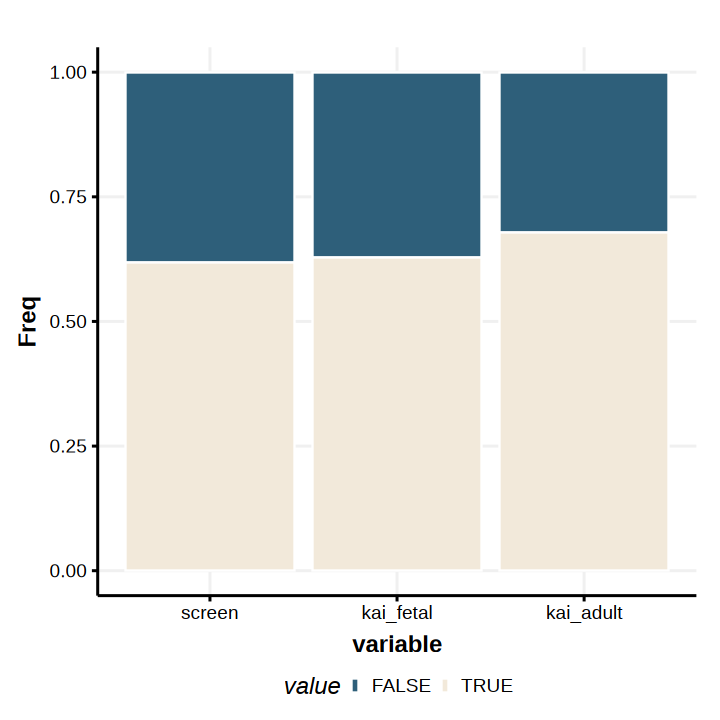

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6)
t1 <- tmp$V1 %>%
as.data.frame %>% setNames("peaks") %>%
mutate(screen = ifelse(peaks %in% tmp$V1[w1], "TRUE", "FALSE")) %>%
mutate(kai_fetal = ifelse(peaks %in% tmp$V1[unique(c(w3, w5))], "TRUE", "FALSE")) %>%
mutate(kai_adult = ifelse(peaks %in% tmp$V1[unique(c(w4, w5))], "TRUE", "FALSE")) %>%
reshape2::melt(id.vars = "peaks") %>%
dplyr::select(c(variable,value)) %>% table %>%
as.data.frame %>%
ggplot(aes(x = variable, y = Freq, fill = value)) + 
geom_col(position = "fill", color = "white") + 
theme_Publication() + 
scale_fill_manual(values = c("#2E5F7A", "#F2E9DA"))

t1

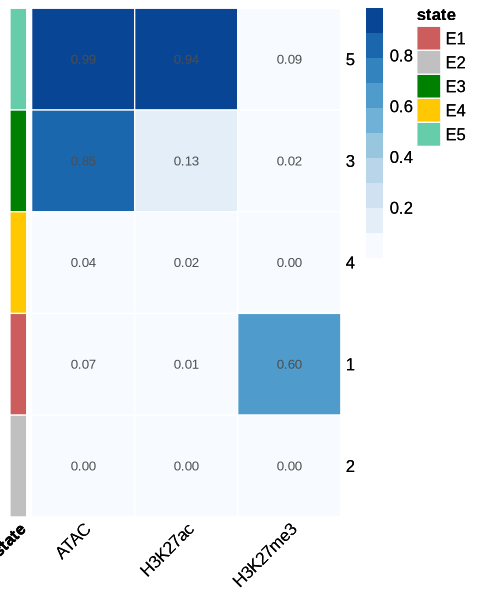

In [34]:
chmstate <- read.table("chromhmm/disease_output/bin200_5_new//emissions_5.txt", sep = "\t", header = T, row.names = 1)

canno <- data.frame(state = paste0("E", 1:5))
rownames(canno) <- rownames(chmstate)
cols <- c("#cd5c5c","#c0c0c0","#008000", "#ffc800", '#66cdaa')
names(cols) <- c("E1", "E2", "E3", "E4", "E5")

options(repr.plot.width = 4, repr.plot.height = 5)
t1 <- chmstate[c(5,3,4,1,2),] %>% 
pheatmap(cluster_rows = F, cluster_cols = F, scale = "none", angle_col = 45, display_numbers = T,
         annotation_row = canno, annotation_colors = list(state = cols),
         border_color = "white", show_rownames = T, show_colnames = T,
         color = colorRampPalette(brewer.pal(n = 8, name = "Blues"))(10))

t1

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


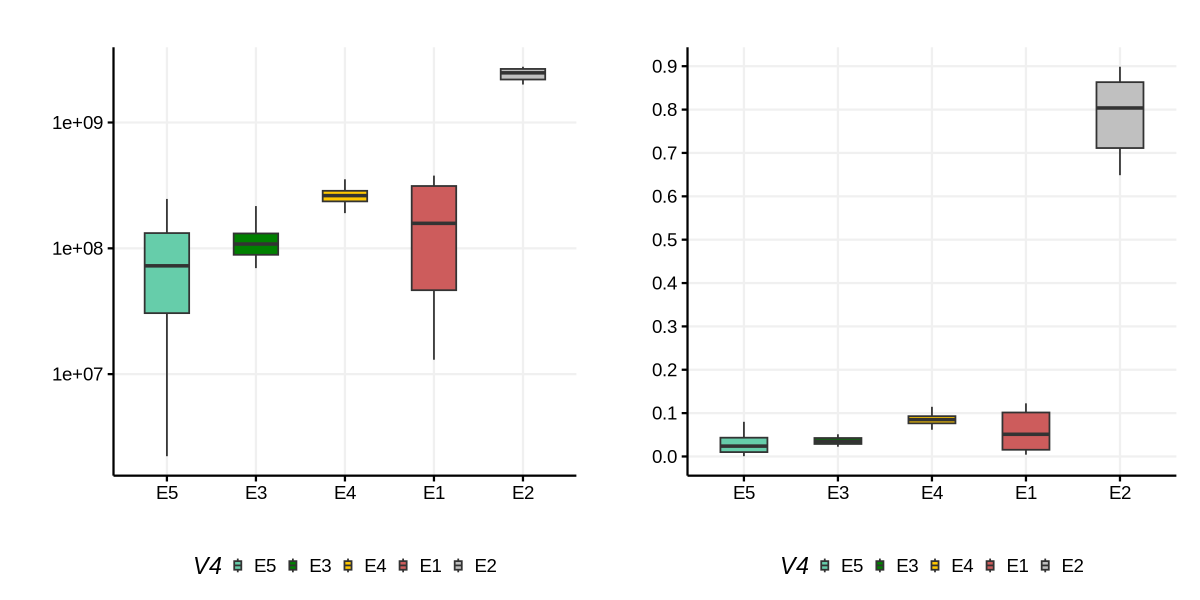

In [1098]:
### Genome coverage?
chmm <- list()
for (f in list.files(paste0(wdir, "chromhmm/celltype/output/"), pattern = ".*_5_segments.bed")){
    fname = gsub("_5_segments.bed", "", f)
    chmm[[f]] <- read.table(paste0(wdir, "chromhmm/celltype/output/", f)) %>% 
    mutate(length = V3 - V2) %>%
    group_by(V4) %>%
    summarise(size = sum(length)) %>%
    ungroup() %>%
    mutate(celltype = fname)
}

library(ggbreak)

t1 <- do.call(rbind, chmm) %>%
mutate(V4 = factor(as.character(V4), levels = c("E5", "E3", "E4", "E1", "E2"))) %>%
ggplot(aes(x = V4, y = size, fill = V4)) + 
geom_boxplot(width = 0.5, position = position_dodge(0.7), coef = 2, outlier.shape = NA) +
theme_Publication() + scale_y_log10() + 
scale_fill_manual(values = cols) +
xlab("") + ylab("")

t2 <- do.call(rbind, chmm) %>% group_by(celltype) %>%
mutate(ratio = size / sum(size)) %>%
mutate(V4 = factor(as.character(V4), levels = c("E5", "E3", "E4", "E1", "E2"))) %>%
ggplot(aes(x = V4, y = ratio, fill = V4)) + 
geom_boxplot(width = 0.5, position = position_dodge(0.7), coef = 2, outlier.shape = NA) +
theme_Publication() +
scale_y_continuous(breaks = seq(0,1,0.1)) + 
scale_fill_manual(values = cols) +
xlab("") + ylab("")

fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)

options(repr.plot.width = 10, repr.plot.height = 5)
fig1

Using V4 as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


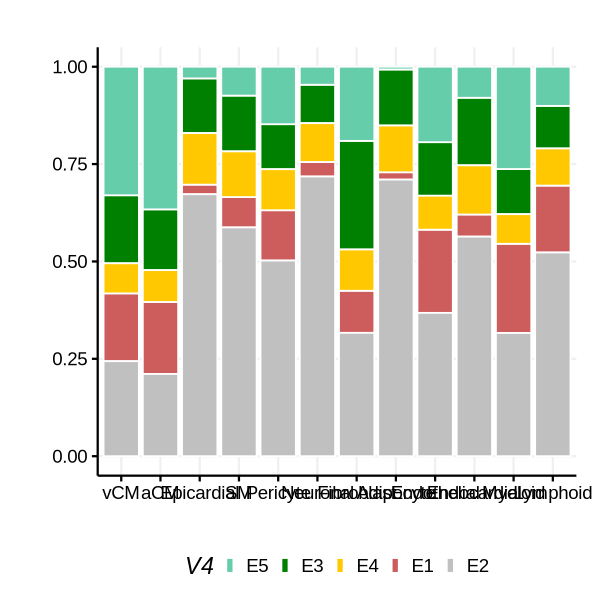

In [1108]:
chmm <- read.table(paste0(wdir, 'chromhmm/celltype/annotate/Heart_UnionPeak_by_celltype.xls'), header = T)

t1 <- apply(chmm, MARGIN = 2, table) %>%
as.data.frame %>% tibble::rownames_to_column("V4") %>%
reshape2::melt() %>%
mutate(V4 = factor(as.character(V4), levels = c("E5", "E3", "E4", "E1", "E2"))) %>%
mutate(variable = factor(variable, levels = corder)) %>%
ggplot(aes(x = variable, y = value, fill = V4)) + 
geom_col(color = "white", position = "fill") +
theme_Publication() + 
scale_fill_manual(values = cols) +
xlab("") + ylab("")

options(repr.plot.width = 5, repr.plot.height = 5)
t1

Using V4 as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


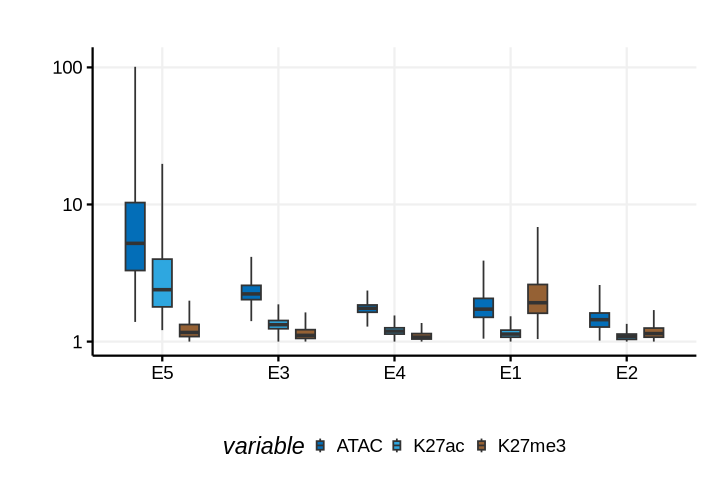

In [36]:
### Plot epigenetic signal
atac <- read.table(paste0(wdir, "reference/ATAC_celltype.cpm.txt"))
k27ac <- read.csv(paste0(wdir, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cpm.csv"), row.names = 1)
k27me3 <- read.csv(paste0(wdir, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.HeartUnionPeak.cpm.csv"), row.names = 1)


options(repr.plot.width = 6, repr.plot.height = 4)
ct <- "vCM"
qchmm <- read.table(paste0("chromhmm/celltype/annotate/Heart_UnionPeak_", ct, "_annotate.bed")) %>% 
mutate(bin = paste0(V1, ":", V2, "-", V3))
qchmm$ATAC <- atac[gsub(":", "-", qchmm$bin), ct]
qchmm$K27ac <- k27ac[qchmm$bin, ct]
qchmm$K27me3 <- k27me3[qchmm$bin, ct]
t1 <- qchmm %>% 
select(c(V4, ATAC, K27ac, K27me3)) %>%
reshape2::melt() %>%
mutate(V4 = factor(as.character(V4), levels = c("E5", "E3", "E4", "E1", "E2"))) %>%
ggplot(aes(x = V4, y = value+1, fill = variable)) + 
geom_boxplot(width = 0.5, position = position_dodge(0.7), coef = 2, outlier.shape = NA) +
theme_Publication() + scale_y_log10() + 
scale_fill_manual(values = c("#036EB8", "#2EA7E0", "#956134")) +
xlab("") + ylab("")

t1

`summarise()` has grouped output by 'V4'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'V4'. You can override using the `.groups` argument.


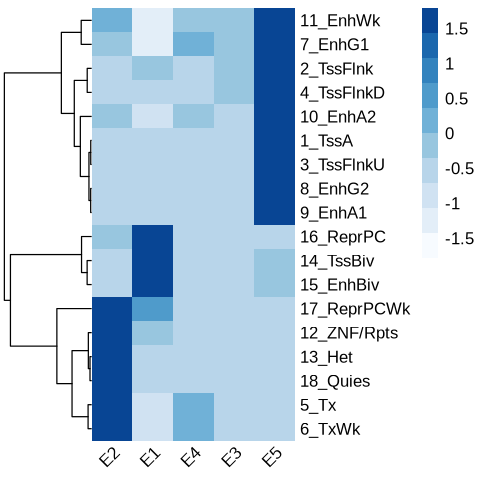

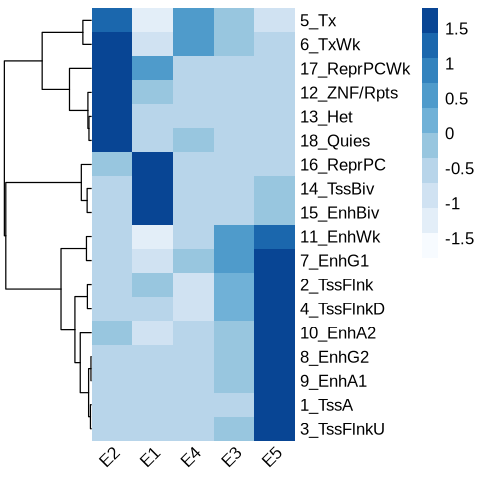

In [90]:
### Compare with epigenome roadmap?
# bedtools intersect -wao -a output/vCM_5_segments.bed -b /projects/ps-renlab2/y2xie/projects/public_data/17.Epigenome_roadmap/mnemonics/E095_18_core_K27ac_mnemonics.hg38.bed > vCM_5_segments_ovlp_095_18_core_K27ac_mnemonics.hg38.bed
scomp <- read.table("/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/05.R/chromhmm/bulk/vCM_5_segments_ovlp_095_18_core_K27ac_mnemonics.hg38.bed")

scompp <- scomp[,c("V4", "V8", "V9")] %>%
group_by(V4, V8) %>%
summarise(leng = sum(V9)) %>%
filter(V8 != ".") %>%
reshape2::dcast(V4 ~ V8, value.var = "leng") %>%
tibble::column_to_rownames("V4")

scompp[is.na(scompp)] <- 0
rmat <- t(scompp[c("E2", "E1", "E4", "E3", "E5"),])
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[(permutation_vector),]

smat %>%
pheatmap(scale = "row", cluster_rows = T, cluster_cols = F, angle_col = 45,
         show_rownames = T, show_colnames = T, border_color = NA, 
         color = colorRampPalette(brewer.pal(n = 8, name = "Blues"))(10))

scomp <- read.table("/projects/ps-renlab2/y2xie/projects/77.LC/81.FNIH_DPT_IGM_240827/05.R/chromhmm/bulk/vCM_5_new_segments_ovlp_095_18_core_K27ac_mnemonics.hg38.bed")

scompp <- scomp[,c("V4", "V8", "V9")] %>%
group_by(V4, V8) %>%
summarise(leng = sum(V9)) %>%
filter(V8 != ".") %>%
reshape2::dcast(V4 ~ V8, value.var = "leng") %>%
tibble::column_to_rownames("V4")

scompp[is.na(scompp)] <- 0
rmat <- t(scompp[c("E2", "E1", "E4", "E3", "E5"),])
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[(permutation_vector),]

t1 <- smat %>%
pheatmap(scale = "row", cluster_rows = T, cluster_cols = F, angle_col = 45,
         show_rownames = T, show_colnames = T, border_color = NA, 
         color = colorRampPalette(brewer.pal(n = 8, name = "Blues"))(10))

### Annotate cCREs with chromatin states

In [140]:
suppressPackageStartupMessages(library(ggalluvial))

chmm <- list()
for (fname in corder){
    f <- paste0("Heart_UnionPeak_", fname, "_annotate.bed")
    chmm[[fname]] <- read.table(paste0(wdir, "chromhmm/celltype/annotate/", f)) %>% 
    mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
    select(c(range, V4)) %>% 
    group_by(range) %>%
    slice_sample(n = 1) %>%
    ungroup() %>%
    tibble::column_to_rownames("range") %>% setNames(fname)
}
commonf <- Reduce(intersect, lapply(chmm, rownames))
for (f in names(chmm)){
    chmm[[f]] <- chmm[[f]][commonf, , drop = F]
}
chmm <- Reduce(cbind, chmm[-1], chmm[[1]]) ### dont use do.call for cbind

In [23]:
smodule <- list() 
for (f in unique(tmp$V3)){
    qpeak <- tmp %>% filter(V3 == f) %>% select(V1) %>% unlist %>% as.character
    smodule[[paste0(f)]] <- chmm[qpeak,] %>% 
    tibble::rownames_to_column("peak") %>%
    reshape2::melt(id.vars = 'peak') %>%
    select(variable, value) %>% table %>%
    as.data.frame %>% mutate(module = f)
}

smodule <- do.call(rbind, smodule)

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


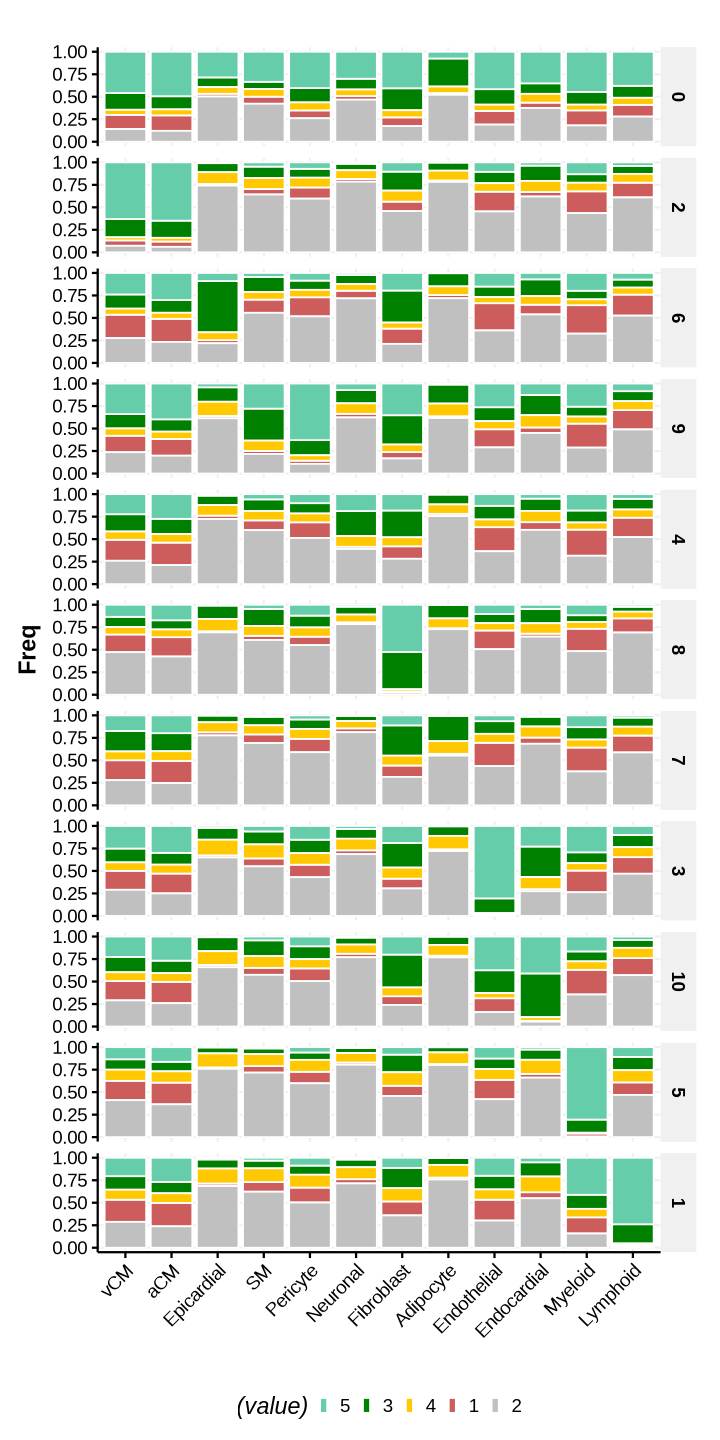

In [25]:
options(repr.plot.width = 6, repr.plot.height = 12)
t1 <- smodule %>%
mutate(variable = factor(variable, levels = corder)) %>% #arrange(variable) %>%
mutate(module = factor(module, levels = c(0,2,6,9,4,8,7,3,10,5,1))) %>%
mutate(value = as.integer(gsub("E", "", value))) %>%
mutate(value = factor(as.character(value), levels = c(5,3,4,1,2))) %>%
ggplot(aes(x = variable, y = Freq, fill = (value))) + 
geom_col(position = "fill", color = "white") + 
theme_Publication() + xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = c('#66cdaa', "#008000", "#ffc800","#cd5c5c","#c0c0c0")) + 
facet_grid(module ~ .)

t1

## Prepare data for ABC model: celltype and disease

In [629]:
### K27ac signal files
k27ac <- read.csv(paste0(widr, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cpm.csv"), row.names = 1) ### FNIH
for (f in colnames(k27ac)){
    tmp <- k27ac[, f, drop = F]
    tmp[,c("chr", "start", "end")] <- stringr::str_split_fixed(rownames(tmp), pattern = "[:-]", n = 3)
    write.table(tmp[,c("chr", "start", "end", f)], paste0("../../87.FNIH_DHC_IGM_240925/05.R/abc//celltype/", f, "_H3K27ac.cpm"),
                row.names = F, col.names = F, sep = "\t", quote = F)
}

In [129]:
### RNA expression with annotation
### FNIH + CAREHF
### "chr", "start", "end", "name" "signal" "strand"
rpkm <- read.table(paste0(wdir, "integration/FNIH_Heart_pool.int.rpkm.txt"), row.names = 1, header = T)
hg38 <- read.table("/projects//ps-renlab/y2xie/projects/genome_ref/Paired-Tag/hg38/hg38.gcode.10X.bed")
for (f in colnames(rpkm)){
    tmp <- merge(hg38, rpkm, by.x = "V6", by.y = 0) %>% select(c(V1, V2, V3, V6, all_of(f), V4))
    tmp$V6 <- make.unique(tmp$V6, sep = "..") ### prevent gene name duplication and we can rescue later
    write.table(tmp, paste0("../../87.FNIH_DHC_IGM_240925/05.R/abc//celltype/", f, "_gex.rpkm"),
                row.names = F, col.names = F, sep = "\t", quote = F)
}

## Check ABC results

In [385]:
aabc <- list()
for (f in corder){
    tmp <- read.table(paste0("../../87.FNIH_DHC_IGM_240925/05.R/atac_abc/celltype/output/", f, "/EnhancerPredictions.txt"), sep = "\t", header = T) #%>% filter(abs(((start+end)/2) - TargetGeneTSS) >= 10000) ### long range only?
    gex <- read.table(paste0("../../87.FNIH_DHC_IGM_240925/05.R/atac_abc/celltype/", f, "_gex.rpkm"), header = F, sep = "\t")
    ac <- read.table(paste0("../../87.FNIH_DHC_IGM_240925/05.R/atac_abc/celltype/", f, "_atac.cpm"), header = F, sep = "\t")
    gex <- gex %>%
    mutate(start = ifelse(V6 == "+", V2, V3-1)) %>%
    mutate(end = ifelse(V6 == "+", V2+1, V3)) %>%
    dplyr::select(c(V1, start, end, V4, V5)) %>% 
    setNames(c("chrom", "start", "end", "TargetGene", "RPKM"))
    tmp <- tmp %>% mutate(range = paste0(chr, ":", start, "-", end))
    ac <- ac %>% setNames(c("chrom", "start", "end", "CPM")) %>% mutate(range = paste0(chrom, ":", start, "-", end))
    
    tmp$CellType <- f
    tmp <- merge(tmp, gex, by = "TargetGene")
    aabc[[f]] <- merge(tmp, ac, by = "range") %>% 
    dplyr::select(c(chr, start.x, end.x,range, name, CPM, chrom.x, start.y, end.y, TargetGene, RPKM, CellType, ABC.Score))
    
}
aabc <- do.call(rbind, aabc)
aabc$TargetGene <- gsub("\\.\\..*", "", aabc$TargetGene)
write.table(aabc, "../../87.FNIH_DHC_IGM_240925/05.R/atac_abc/FNIH_heart_celltype_abc_links.txt", 
           sep = "\t", quote = F, row.names = F, col.names = T)

system("mkdir ../../87.FNIH_DHC_IGM_240925/05.R/atac_abc/celltype/output/abc_bedpe")
aabc <- aabc %>% filter(abs(((start.x+start.x)/2) - start.y) >= 10000)
write.table(aabc, "../../87.FNIH_DHC_IGM_240925/05.R/atac_abc/celltype/output/abc_bedpe/abc_lite_distalpairs.tsv", 
           sep = "\t", quote = F, row.names = F, col.names = T)

In [386]:
dim(aabc)
table(aabc$CellType)

[1] 71824    13


        aCM   Adipocyte Endocardial Endothelial  Epicardial  Fibroblast 
       4217        5223        6035        7696        4892        4813 
   Lymphoid     Myeloid    Neuronal    Pericyte          SM         vCM 
       8989        6306        7096        7342        5239        3976 

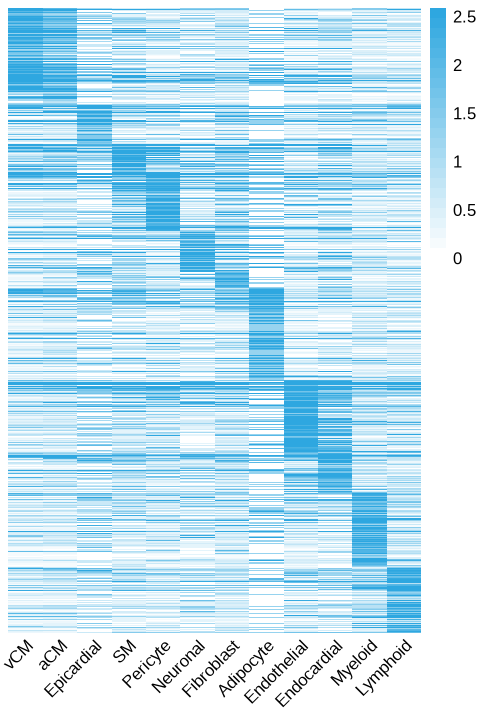

In [196]:
### Create heatmap: all links
options(repr.plot.width = 4, repr.plot.height = 6)

k27ac <- read.csv("FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.HeartUnionPeak.cpm.csv", row.names = 1) ### FNIH
rmat <- k27ac[sub("-", ":", unique(abc$range)), corder]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]
smat[smat>5] <- 5

options(repr.plot.width = 4, repr.plot.height = 6)
t1 <- log2(smat + 1) %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F, angle_col = 45, #gaps_row = unlist(gaprow),
         show_rownames = F, # annotation_colors = ccolor, annotation_row = ranno, 
         border_color = NA, color = colorRampPalette(c("white", "#2EA7E0"))(25))

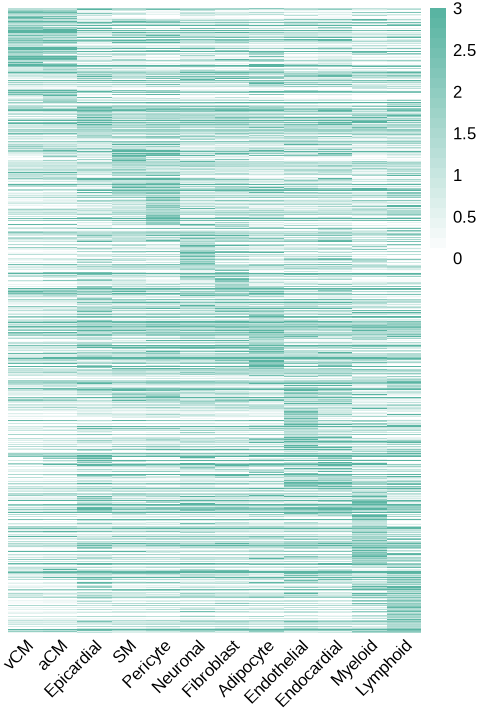

In [200]:
rpkm <- read.table("integration/FNIH_Heart_pool.int.rpkm.txt", row.names = 1, header = T)
ssmat <- log2(rpkm[abc[match(rownames(smat), sub("-", ":", abc$range)),]$TargetGene, corder] + 1)
ssmat[ssmat > 3] <- 3

t2 <- ssmat %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F, angle_col = 45, #gaps_row = unlist(gaprow),
         show_rownames = F, # annotation_colors = ccolor, annotation_row = ranno, 
         border_color = NA, color = colorRampPalette(c("white", "#59b4a2"))(25))

## Identify cell type specific cCREs

In [ ]:
!Rscript ~/scripts/DPT/snapATAC2.JSStest.R -i ../../ATAC_processed_peaks.h5ad -a cell.major_types -l snapatac2_LR_test.csv --path_to_peak ../ -o FNIH_Heart

In [625]:
### Read in celltype specific peaks
jssdf <- data.table::fread(paste0(wdir, "reference/FNIH_peaks/LR/FNIH_Heart.JSStest.out.tsv"))
jssdf %>% filter(group == "diff") %>% dplyr::select(attr) %>% table
jssdf %>% filter(group == "diff" & passJSS == "yes") %>% dplyr::select(attr) %>% table

attr
        aCM   Adipocyte Endocardial Endothelial  Epicardial  Fibroblast 
      19045        4844        3650        5343        7974        2933 
   Lymphoid     Myeloid    Neuronal    Pericyte          SM         vCM 
       5086        2822        3456        4795        3791       19055 

attr
        aCM   Adipocyte Endocardial Endothelial  Epicardial  Fibroblast 
       9244        2383        1129        1317        3538         777 
   Lymphoid     Myeloid    Neuronal    Pericyte          SM         vCM 
       1254        1275        1391        1102        1268       10269 

In [627]:
### Find peaks specific to some or one cell types
cts <- jssdf %>% filter(passJSS == "yes" & group == "diff") %>% 
dplyr::select(c(peaks, attr)) %>% table %>%
as.data.frame %>% filter(Freq > 0) %>%
group_by(peaks) %>% summarise(celltype = paste0(attr, collapse = "|")) %>%
ungroup

In [628]:
ctp <- cts[grep("\\|", cts$celltype, invert = T), ] %>%
mutate(celltype = factor(celltype, levels = corder)) %>% 
arrange(celltype)
dim(ctp)
dim(cts)

[1] 20267     2

[1] 27524     2

Warning message in gaprow$SM <- NULL:
“Coercing LHS to a list”


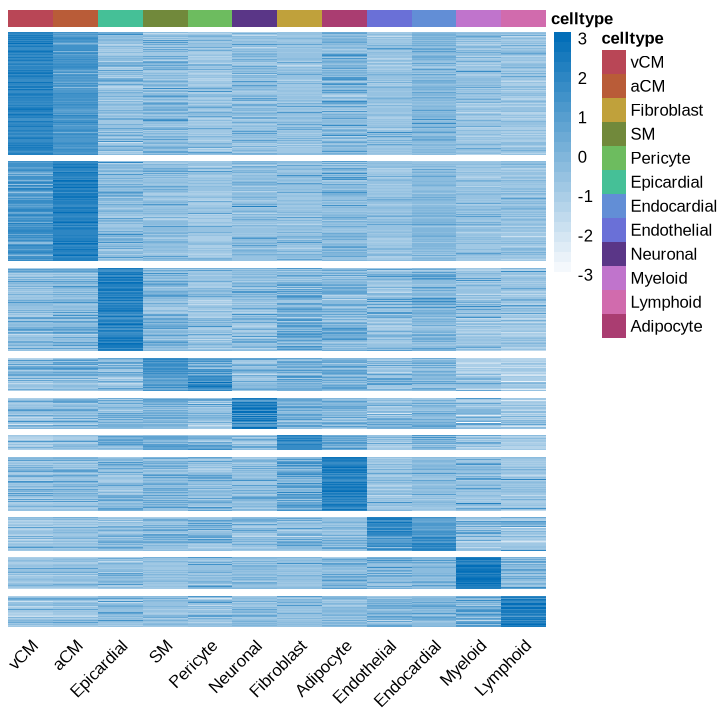

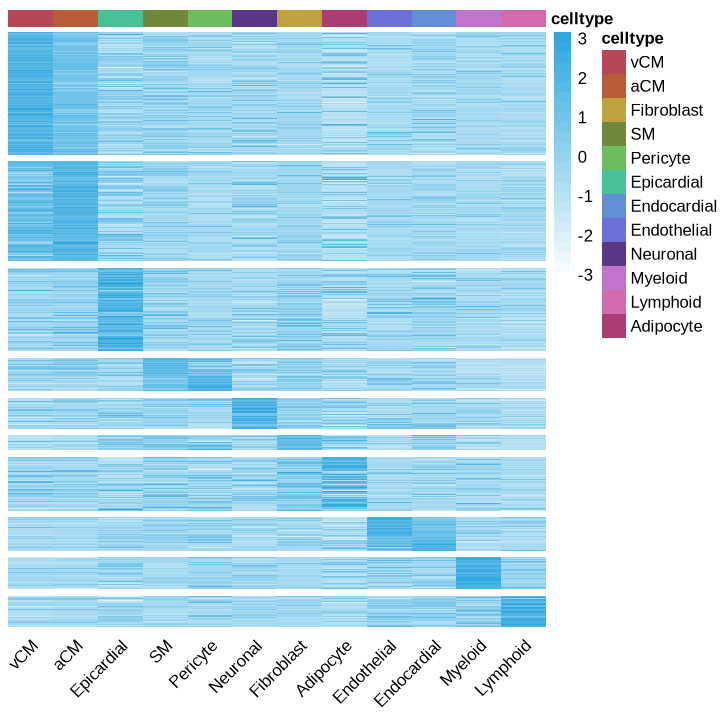

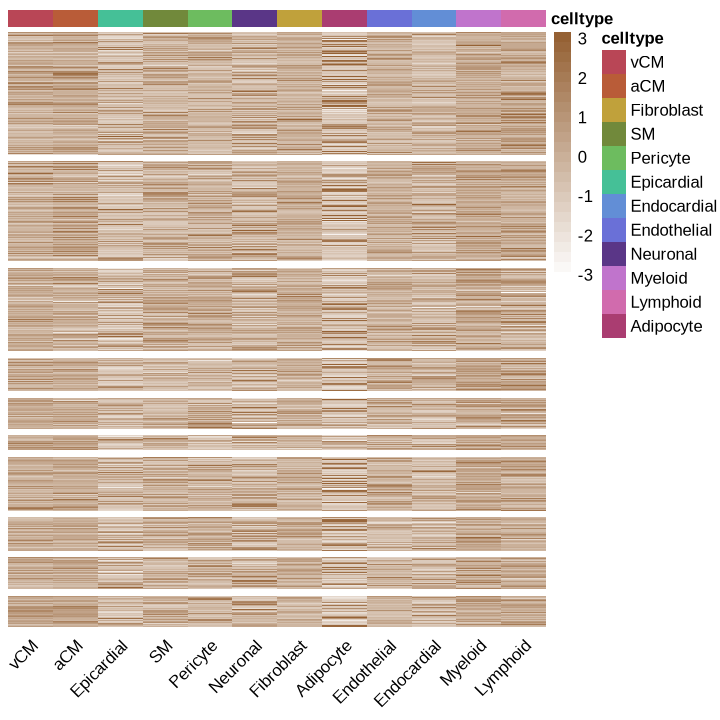

In [1313]:
rmat <- atac[sub(":", "-", as.character(ctp$peaks)), corder]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat #[permutation_vector, ]

smat[smat > 32] <- 32
canno <- data.frame(colnames(atac)) %>% setNames("celltype")
rownames(canno) <- canno$celltype
ccolor <- list(celltype = c(celltype_colors))

gaprow <- cumsum(table(ctp$celltype))
gaprow$SM <- NULL
gaprow$Endothelial <- NULL

options(repr.plot.width = 6, repr.plot.height = 6)
t1 <- log2(smat + 1) %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, gaps_row = unlist(gaprow),
         show_rownames = F, annotation_colors = ccolor, #annotation_row = ranno, 
         annotation_col = canno,
         border_color = NA, color = colorRampPalette(c("white", "#036EB8"))(25))

smat1 <- log2(k27ac[sub("-", ":", rownames(smat)), colnames(smat)] + 1)
smat1[smat1 > 5] <- 5
t2 <- smat1 %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, gaps_row = unlist(gaprow),
         show_rownames = F, annotation_colors = ccolor, #annotation_row = ranno, 
         annotation_col = canno,
         border_color = NA, color = colorRampPalette(c("white", "#2EA7E0"))(25))

smat2 <- log2(k27me3[sub("-", ":", rownames(smat)), colnames(smat)] + 1)
smat2[smat2 > 2] <- 2
t3 <- smat2 %>%
pheatmap(scale = "row",cluster_rows = F, cluster_cols = F, angle_col = 45, gaps_row = unlist(gaprow),
         show_rownames = F, annotation_colors = ccolor, #annotation_row = ranno, 
         annotation_col = canno,
         border_color = NA, color = colorRampPalette(c("white", "#956134"))(25))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


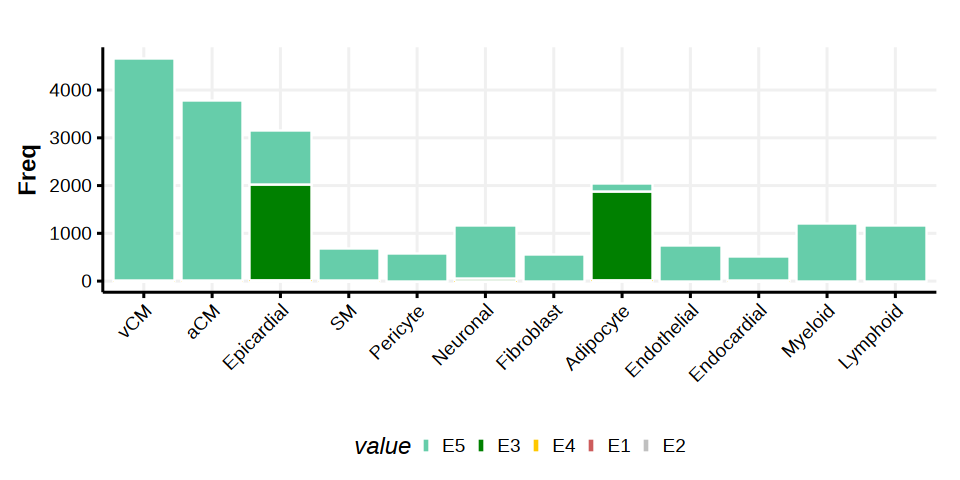

In [632]:
### chromatin states of cts?
options(repr.plot.width = 8, repr.plot.height = 4)
t1 <- smodule %>%
filter(variable == module) %>%
mutate(variable = factor(as.character(variable), levels = corder)) %>% #arrange(variable) %>%
mutate(value = factor(as.character(value), levels = paste0("E", c(5,3,4,1,2)))) %>%
ggplot(aes(x = variable, y = Freq, fill = value)) + 
geom_col(position = "fill", color = "white") + theme_Publication() + 
# coord_polar(theta = "y") + theme_void() +
xlab("") + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
scale_fill_manual(values = c('#66cdaa', "#008000", "#ffc800","#cd5c5c","#c0c0c0")) # + facet_grid(variable ~ .)

t1

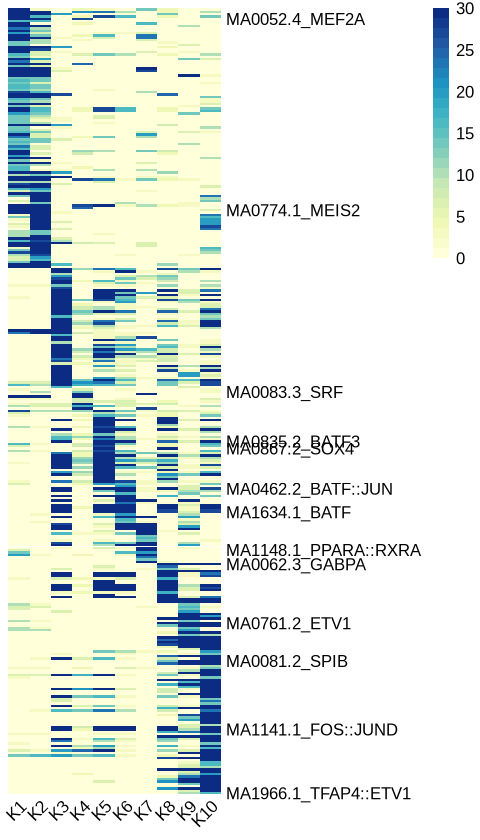

In [334]:
### cts motif
motif <- read.csv(paste0("motif/cts_cCRE_motif_LT_250130.txt"), sep = "\t") %>%
setNames(c('motif', 'Consensus', 'p_value', 'Log_Pvalue', 'fdr', "target_num", "target_pct", "bgd_num", "bgd_pct", 
           'FoldEnrichment','celltype','Motif_ID','ID','group','x_labels'))

vmotif <- motif %>% group_by(motif) %>% 
filter(min(fdr) < 0.05) %>% ungroup() %>%
select(motif) %>% unlist %>% unique

motif <- motif %>%
filter(motif %in% vmotif) %>%
reshape2::dcast(group ~ motif, value.var = "p_value", fun.aggregate = mean) %>%
tibble::column_to_rownames("group") %>% t
motif[is.na(motif)] <- 1
motif <- -log2(motif)
motif[motif > 30] <- 30

rmat <- motif[, paste0("K", 1:10)]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]

### Only label max score
llabel <- c("MEF2A", "MEIS2", "PPARA", "SRF", "SOX4", 
            "BATF", "FOS::JUND", "GABPA", "SPIB", "ETV1")
llabel <- grep(paste0(llabel, collapse = "|"), rownames(smat), value = T)
labs.row <- rownames(smat)
labs.row[!(labs.row %in% llabel)] <- ""

t1 <- smat %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F, angle_col = 45, border_color = "black",
         show_rownames = T, labels_row = labs.row,
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

## Cell type specific ABC links

In [12]:
abc <- read.table("../../87.FNIH_DHC_IGM_240925/05.R/abc/FNIH_heart_celltype_abc_links.txt", header = T)
dim(abc)

[1] 121473     13

In [15]:
distinct(abc[,c(4,10)]) %>% dim

[1] 66317     2

In [62]:
### Celltype specific links: those overlap celltype specific elements
abc_unique <- merge(abc[,c("range", "TargetGene", "CellType")], cts[cts$peaks %in% ctp$peaks,], by.x = "range", by.y = "peaks") %>%
filter(CellType == celltype) %>%
mutate(CellType = factor(CellType, levels = corder)) %>%
arrange(CellType) %>% distinct

nrow(abc_unique)
nrow(distinct(abc_unique[,1:2]))

[1] 11936

[1] 11936

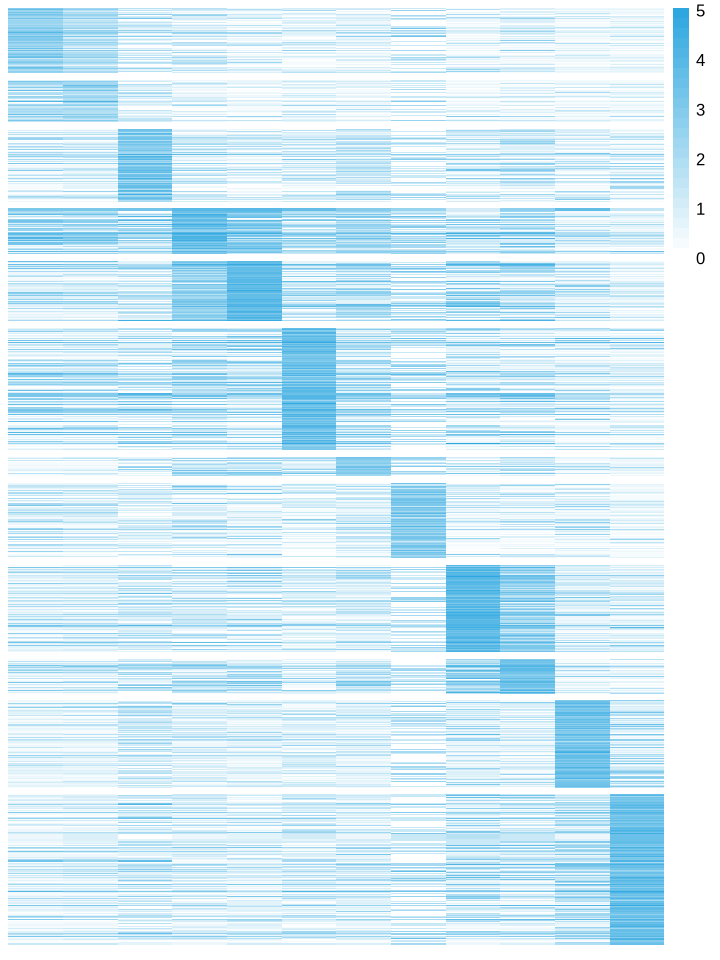

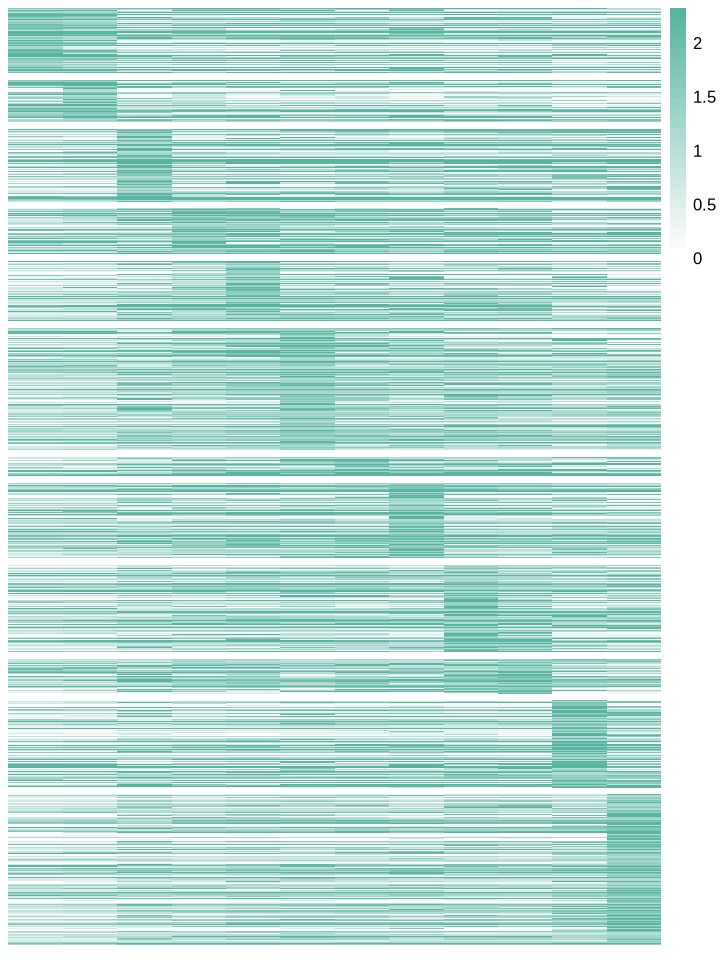

In [67]:
options(repr.plot.width = 6, repr.plot.height = 8)
smat <- k27ac[abc_unique$range, corder]
smat[smat > 32] <- 32
t1 <- log2(smat + 1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, border_color = NA, 
         gaps_row = cumsum(table(abc_unique$CellType)),
         scale = "none", angle_col = 45, 
         show_rownames = F, show_colnames = F,
         color = colorRampPalette(c("white", "#2EA7E0"))(25))

ssmat <- rpkm[abc_unique$TargetGene, corder]
ssmat[ssmat > 4] <- 4
t2 <- log2(ssmat + 1) %>%
pheatmap(cluster_rows = F, cluster_cols = F, border_color = NA,
         gaps_row = cumsum(table(abc_unique$CellType)),
         scale = "none", angle_col = 45, 
         show_rownames = F, show_colnames = F,
         color = colorRampPalette(c("white", "#59b4a2"))(25))

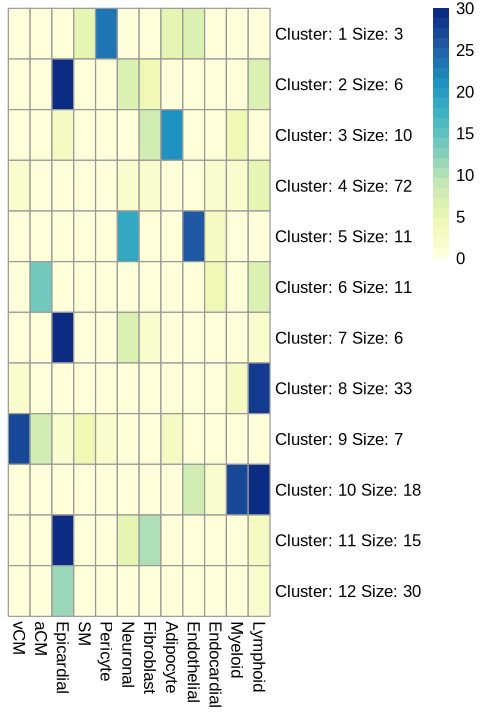

In [303]:
### Read cts link motifs
motif <- list()
for (f in corder){
    motif[[f]] <- read.csv(paste0("../../87.FNIH_DHC_IGM_240925/05.R/abc/CellTypeSpecific_Enhancer_Motifs/knownResults_", f, ".txt"), sep = "\t", row.names = 1) %>%
    setNames(c("consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    tibble::rownames_to_column("motif") %>% mutate(celltype = f)
}
vmotif <- do.call(rbind, motif) %>% group_by(motif) %>% 
filter(min(fdr) < 0.05) %>% ungroup() %>%
select(motif) %>% unlist %>% unique

motif <- do.call(rbind, motif) %>%
filter(motif %in% vmotif) %>%
reshape2::dcast(celltype ~ motif, value.var = "p_value") %>%
tibble::column_to_rownames("celltype") %>% t
motif[is.na(motif)] <- 1
motif <- -log2(motif)
motif[motif > 30] <- 30

rmat <- motif[, corder]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]

rmat <- motif[, corder]
max_indices <- max.col(rmat)
permutation_vector <- order(max_indices)
smat <- rmat[permutation_vector, ]

set.seed(921)
f1 <- smat %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F, kmeans_k = length(corder), 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

In [304]:
rorder <- f1$kmeans$cluster %>% as.data.frame %>% setNames("cluster") %>%
mutate(cluster = factor(cluster, levels = c(9,1,5,2,7,12,11,4,8,3,6,10))) %>%
arrange(cluster)

ttp <- smat[rownames(rorder),] %>% t %>% as.data.frame %>% 
tibble::rownames_to_column("celltype") %>%
reshape2::melt() %>%
mutate(celltype = factor(celltype, levels = rev(corder))) %>%
mutate(variable = factor(variable, levels = rownames(rorder)))

vltp <- table(rorder$cluster) %>%
as.data.frame %>%
select(Freq) %>% unlist %>% cumsum

Using celltype as id variables



Adding missing grouping variables: `cluster`


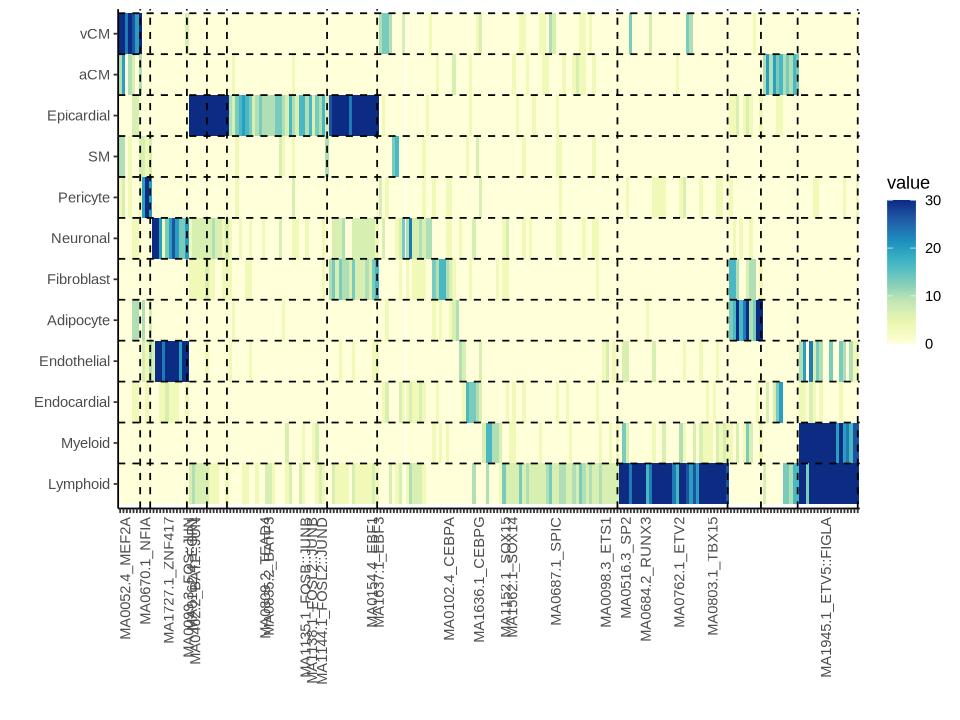

In [305]:
llabel <- c("MEF2C", "MEF2D", "KLF1", "KLF10", "GATA6", "TBX4", "NFIA", "TWIST1", 
            "NFIL3", "SPIC", "EHF", "SOX18", "FOSL1", "FOS", "SPIB", 
            "IKZF1", "ERF", "GABPA", "SOX9", "SOX15", "ETV1")
llabel <- grep(paste0(llabel, collapse = "|"), rownames(smat), value = T)
llabel <- f1$kmeans$cluster %>% as.data.frame %>% setNames("cluster") %>%
tibble::rownames_to_column("motif") %>%
group_by(cluster) %>%
slice_sample(n = 2) %>% select(motif) %>% unlist

labs.row <- rownames(smat)
labs.row[!(labs.row %in% llabel)] <- ""

options(repr.plot.width = 8, repr.plot.height = 6)

t1 <- ttp %>%
ggplot(aes(x = variable, y = celltype, fill = value)) + 
geom_tile() + ylab("") + xlab("") + 
geom_hline(yintercept = seq(1.5, length(unique(ttp$celltype)) + 0.5, by = 1),  # Add lines between rows
           linetype = "dashed", color = "black") +
geom_vline(xintercept = vltp, linetype = "dashed", color = "black") +
theme_classic() + 
scale_x_discrete(labels = labs.row) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + 
scale_fill_gradientn(colours = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

t1

## DE genes in HF

Using celltype as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


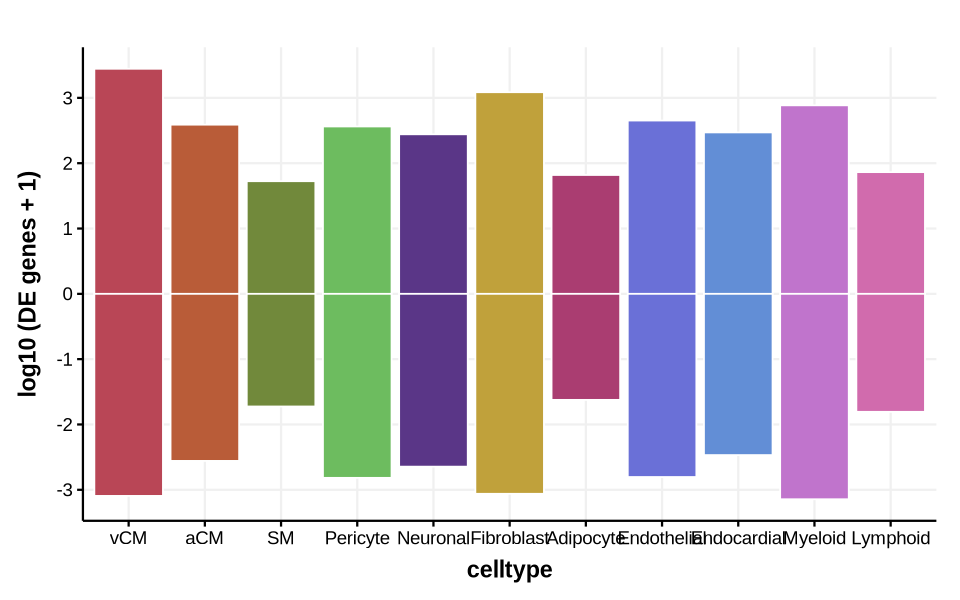

In [33]:
genede <- read.table(paste0(wdir, "/reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_RNA.dds.res"), header = T) %>%
filter(RNA_Padj < 0.05) %>%
setNames(c("celltype", "contrast", "gene", "log2FoldChange", "stat", "pvalue", "padj"))

options(repr.plot.width = 8, repr.plot.height = 5)
t1 <- genede %>%
group_by(celltype) %>%
summarise(up_padj = log10(sum(log2FoldChange >= 0.5)+1), down_padj = -log10(sum(log2FoldChange <= -0.5)+1)) %>%
ungroup %>%
select(c(celltype, up_padj, down_padj)) %>%
reshape2::melt() %>% mutate(celltype = factor(celltype, levels = corder)) %>%
ggplot(aes(x = celltype, y = value, fill = celltype)) + 
geom_col(position = "dodge", color = "white") + 
theme_Publication() + ylab("log10 (DE genes + 1)") + 
scale_y_continuous(breaks = seq(-4, 4,1)) + 
scale_fill_manual(values = celltype_colors) + NoLegend()

t1

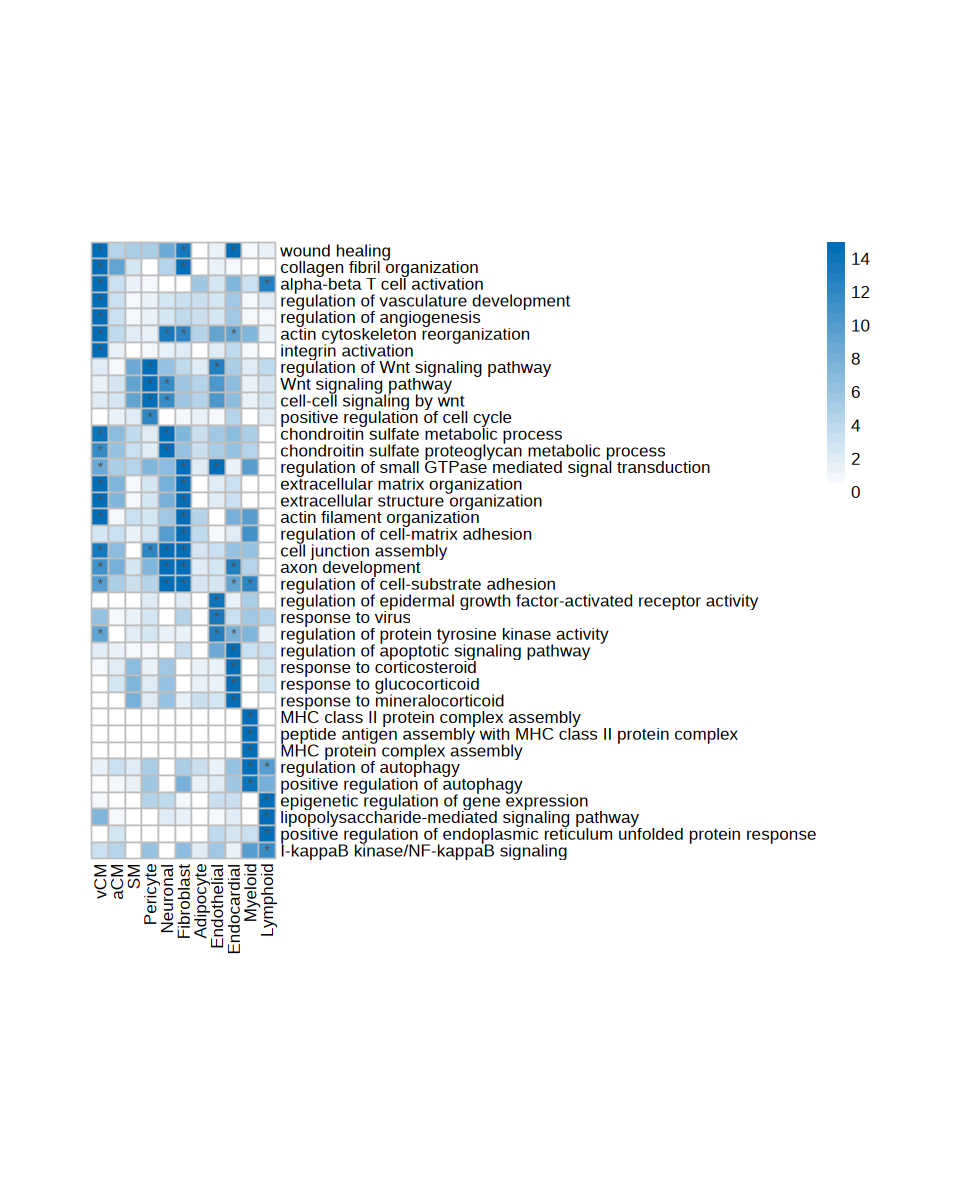

In [510]:
### Load enrichGO term for down and up-regulated genes
term1 <- read.table("DEgene_up_enrichGO_term_EF.txt", sep = "\t")
tmp <- tmp1 %>% 
reshape2::dcast(Description ~ celltype, value.var = "pvalue", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1
tmp <- -log2(tmp)

ttp <- tmp[unique(term1$V1), intersect(corder, unique(tmp1$celltype))]
ttp[ttp > 15] <- 15
max_indices <- max.col(ttp)
permutation_vector <- order(max_indices)
smat <- ttp[permutation_vector, ]

lmat <- tmp1 %>% 
mutate(value = p.adjust) %>%
reshape2::dcast(Description ~ celltype, value.var = "value", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description") 

lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

options(repr.plot.width = 8, repr.plot.height = 10)
t1 <- smat %>%
pheatmap(cluster_cols = F, cluster_rows = F, border_color = "gray", angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat[rownames(smat), colnames(smat)], # breaks = seq(-4,4,0.4),
         color = colorRampPalette(c("white", "#036EB8"))(25))

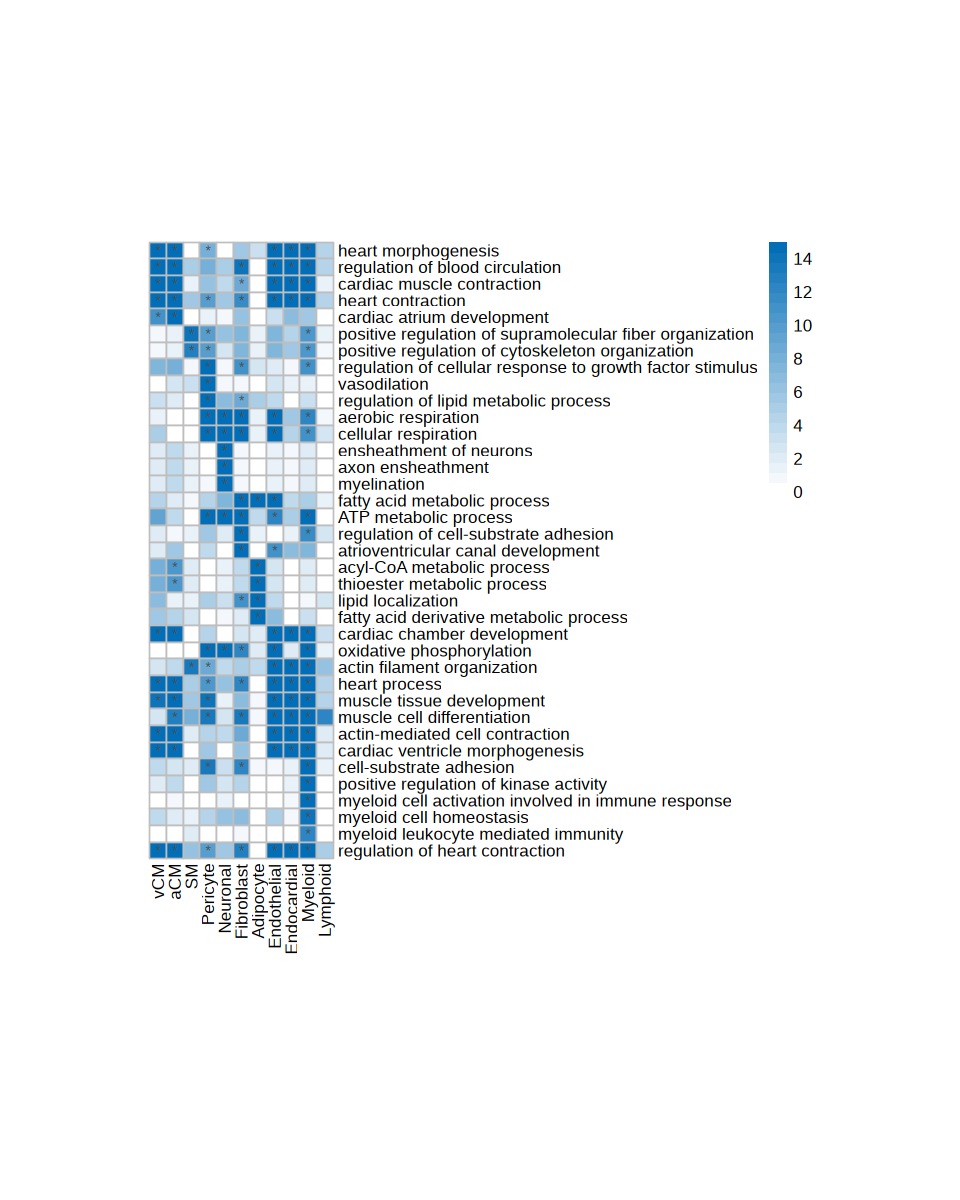

In [517]:
term2 <- read.table("DEgene_down_enrichGO_term_EF.txt", sep = "\t")
tmp <- tmp2 %>% 
reshape2::dcast(Description ~ celltype, value.var = "pvalue", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description")
tmp[is.na(tmp)] <- 1
tmp <- -log2(tmp)

ttp <- tmp[unique(term2$V1), intersect(corder, unique(tmp2$celltype))]
ttp[ttp > 15] <- 15
max_indices <- max.col(ttp)
permutation_vector <- order(max_indices)
smat <- ttp[permutation_vector, ]

lmat <- tmp2 %>% 
mutate(value = p.adjust) %>%
reshape2::dcast(Description ~ celltype, value.var = "value", fun.aggregate = mean) %>%
tibble::column_to_rownames("Description") 

lmat[is.na(lmat)] <- 1
lmat <- ifelse(lmat < 0.05, "*", "")

options(repr.plot.width = 8, repr.plot.height = 10)
t2 <- smat %>%
pheatmap(cluster_cols = F, cluster_rows = F, border_color = "gray", angle_col = 90, cellwidth = 10, cellheight = 10,
         display_numbers = lmat[rownames(smat), colnames(smat)], # breaks = seq(-4,4,0.4),
         color = colorRampPalette(c("white", "#036EB8"))(25))

## DAR in HF

In [ ]:
## import chromatin states, CPM and DAR results
chmm <- list()
for (f in list.files("chromhmm/disease_annotate/", pattern = "^Heart_UnionPeak.*")){
    fname = gsub("_annotate.bed", "", f)
    chmm[[f]] <- read.table(paste0("chromhmm/disease_annotate/", f)) %>% 
    mutate(range = paste0(V1, ":", V2, "-", V3)) %>%
    dplyr::select(c(range, V4)) %>% 
    group_by(range) %>%
    slice_sample(n = 1) %>%
    ungroup() %>%
    tibble::column_to_rownames("range") %>% setNames(fname)
}
commonf <- Reduce(intersect, lapply(chmm, rownames))
for (f in names(chmm)){
    chmm[[f]] <- chmm[[f]][commonf, , drop = F]
}
chmm <- Reduce(cbind, chmm[-1], chmm[[1]]) ### dont use do.call for cbind

In [ ]:
atac <- read.table(paste0(wdir, "/reference/ATAC_celltype_HF.cpm.txt"))
k27ac <- read.csv(paste0(wdir, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27ac.disease.HeartUnionPeak.cpm.csv"), row.names = 1)
k27me3 <- read.csv(paste0(wdir, "FNIH_Heart_signal/FNIH_Heart_pool.H3K27me3.disease.HeartUnionPeak.cpm.csv"), row.names = 1)
colnames(atac) <- gsub("NON.HF", "CONTROL", colnames(atac))

rpkm <- read.table(paste0(wdir, "integration/FNIH_Heart_pool.int.disease.rpkm.txt"))

In [240]:
atacder <- read.table(paste0(wdir, "reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_ATAC.dds.res"), header = T) %>%
setNames(c("celltype", "contrast", "range", "log2FoldChange", "stat", "pvalue", "padj"))

geneder <- read.table(paste0(wdir, "../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_RNA.dds.res"), header = T) %>%
setNames(c("celltype", "contrast", "gene", "log2FoldChange", "stat", "pvalue", "padj"))

In [192]:
atacde <- read.table("../reference/Multiome_Downstream/CHAMBER/4chambers_DESEQ2_ATAC.dds.res", header = T) %>%
filter(ATAC_Padj < 0.05) %>%
setNames(c("celltype", "contrast", "range", "log2FoldChange", "stat", "pvalue", "padj"))

atacde %>% filter(log2FoldChange > 0) %>% dplyr::select(celltype) %>% table
atacde %>% filter(log2FoldChange < 0) %>% dplyr::select(celltype) %>% table

celltype
        aCM Endocardial Endothelial  Fibroblast     Myeloid    Neuronal 
       2561         101        1814        8566        2161          72 
   Pericyte          SM         vCM 
        718          37       13163 

celltype
        aCM Endocardial Endothelial  Fibroblast    Lymphoid     Myeloid 
       1812          25         840        9726           1        1960 
   Neuronal    Pericyte          SM         vCM 
         37         732          25       15394 

In [233]:
### Check correlation of ATAC DA with gene expression DE
### signal over tss:
suppressPackageStartupMessages(library(GenomicRanges))
tss <- read.table("/projects/ps-renlab2/y2xie/ps-renlab/y2xie/projects/genome_ref/refdata-cellranger-arc-GRCh38-2020-A-2.0.0/regions/tss_1500bp.bed")
tsrange <- GenomicRanges::GRanges(tss$V1, IRanges::IRanges(tss$V2, tss$V3))
atrange <- stringr::str_split_fixed(atacde$range, pattern = "[-:]", n = 3)
atrange <- GenomicRanges::GRanges(atrange[,1], IRanges::IRanges(as.integer(atrange[,2]), as.integer(atrange[,3])))

ppeak <- atacde$range[queryHits(findOverlaps(atrange, tsrange))] %>% unique

tdata <- atacde[queryHits(findOverlaps(atrange, tsrange)),]
tdata$tss <- tss[subjectHits(findOverlaps(atrange, tsrange)),]$V7

Using celltype as id variables

Warning message:
“Removed 10 rows containing missing values or values outside the scale range (`geom_point()`).”


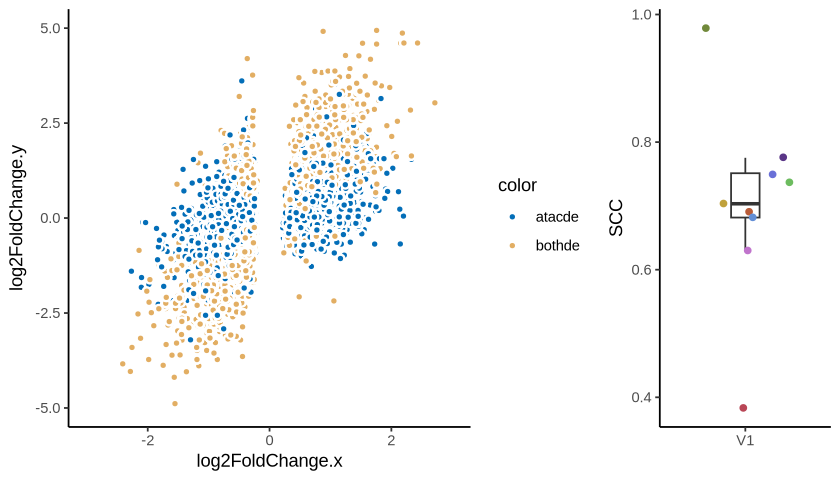

In [268]:
flist <- list()
for (f in unique(tdata$celltype)){
    qqq <- tdata %>% filter(celltype == f)
    qgene <- geneder %>% filter(celltype == f)
    qqq <- merge(qqq, qgene, by.x = "tss", by.y = "gene")
    flist[[f]] <- qqq %>%
    mutate(color = ifelse(padj.y < 0.05, "bothde", "atacde"))
}
t1 <- do.call(rbind, flist) %>%
ggplot(aes(x = log2FoldChange.x, y = log2FoldChange.y, fill = color)) + 
geom_point(color = "white", stroke = 1, shape = 21) + 
theme_classic() + xlim(-3, 3) + ylim(-5, 5) + #ggtitle("all pairs") + 
scale_fill_manual(values = c("#036EB8", "#E2AE63"))

t2 <- flist %>%
lapply(function(x) cor(x$log2FoldChange.x, x$log2FoldChange.y, method = "spearman")) %>%
as.data.frame %>% t %>% as.data.frame %>% tibble::rownames_to_column("celltype") %>%
reshape2::melt() %>%
ggplot(aes(x = variable, y = value)) + 
geom_boxplot(width = 0.2, fill = "white", coef = 2, outlier.shape = NA) + 
geom_jitter(aes(color = celltype)) + 
theme_classic() + xlab("") + ylab("SCC") + 
scale_color_manual(values = celltype_colors) + 
NoLegend()

options(repr.plot.width = 7, repr.plot.height = 4)
fig1 <- cowplot::plot_grid(t1, t2, rel_widths = c(1, 0.4))

In [521]:
data <- read.table("plot/FIG_ATACDE_ovlp_TSS_GENEDE.txt", sep = "\t", header = T)
cor.test(data$log2FoldChange.x, data$log2FoldChange.y)


	Pearson's product-moment correlation

data:  data$log2FoldChange.x and data$log2FoldChange.y
t = 122.61, df = 21249, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6357540 0.6515035
sample estimates:
      cor 
0.6436969 


In [852]:
### Fig3A: plot all modalities together
de_list <- list()
for (f in list.files("../reference/Multiome_Downstream//15kb_BinnedCounts", pattern = ".dds.res$")){
    fname <- gsub("_H3K27me3_HF_vs_NON_HF.dds.res", "", f)
    de_list[[fname]] <- read.table(paste0("../reference/Multiome_Downstream//15kb_BinnedCounts/", f), header = T) %>%
    filter(padj < 0.05, abs(log2FoldChange) >= 0.5) %>% mutate(group = ifelse(log2FoldChange > 0, "up", "down")) %>%
    mutate(celltype = fname) %>%
    tibble::rownames_to_column("bin")
}

de_list <- do.call(rbind, de_list)

f1 <- atacde %>%
group_by(celltype) %>%
summarise(up_padj = log10(sum(log2FoldChange > 0)+1), down_padj = -log10(sum(log2FoldChange < -0)+1)) %>%
ungroup %>% mutate(mod = "ATAC")

f2 <- genede %>%
group_by(celltype) %>%
summarise(up_padj = log10(sum(log2FoldChange > 0)+1), down_padj = -log10(sum(log2FoldChange < -0)+1)) %>%
ungroup %>% mutate(mod = "RNA")

f3 <- read.table("../reference/4Chambers_Ac_ATACpeaks/HFnonHF_ResultsSummaries.tsv") %>%
mutate(celltype = gsub("([^_]+)_([^_]+)", "\\1", celltype)) %>%
mutate(up_padj = log10(up_padj + 1), down_padj = -log10(down_padj + 1)) %>%
dplyr::select(celltype, up_padj, down_padj) %>% mutate(mod = "H3K27ac")

f4 <- de_list %>%
group_by(celltype) %>%
summarise(up_padj = log10(sum(log2FoldChange > 0)+1), down_padj = -log10(sum(log2FoldChange < -0)+1)) %>%
ungroup %>% mutate(mod = "H3K27me3")

Using celltype, mod as id variables

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


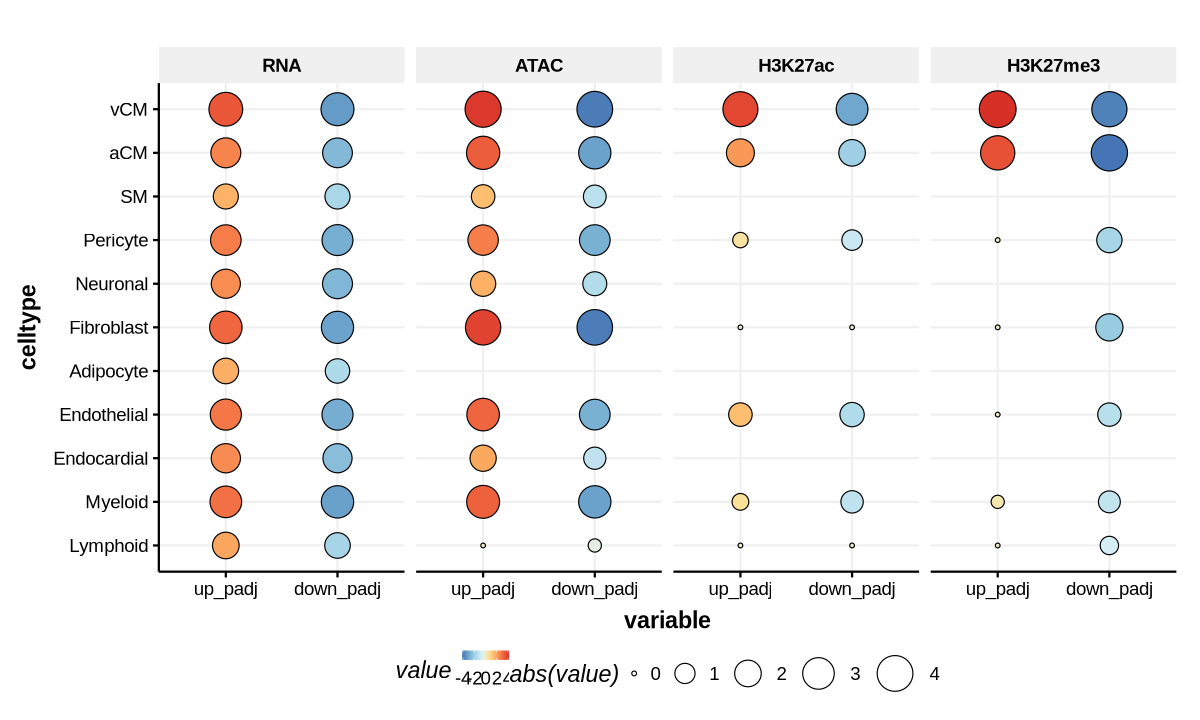

In [857]:
options(repr.plot.width = 10, repr.plot.height = 6)

t1 <- do.call(rbind, list(f1, f2, f3, f4)) %>%
reshape2::melt() %>% 
mutate(celltype = factor(celltype, levels = rev(corder))) %>%
mutate(mod = factor(mod, levels = c("RNA", "ATAC", "H3K27ac", "H3K27me3"))) %>%
ggplot(aes(x = variable, y = celltype, size = abs(value), fill = value)) + 
geom_point(color = "black", stroke = 0.5, shape = 21) + 
theme_Publication() + 
scale_size(range = c(1, 10)) + 
scale_fill_gradientn(colours = rev(colorRampPalette(brewer.pal(n = 8, name = "RdYlBu"))(20))) + 
facet_grid(. ~ mod)

t1

In [522]:
### How many of the ATAC DA peaks are distal?
atacde %>% filter(log2FoldChange >= 0, !(range %in% ppeak)) %>% dplyr::select(celltype) %>% table
atacde %>% filter(log2FoldChange <= 0, !(range %in% ppeak)) %>% dplyr::select(celltype) %>% table

celltype
        aCM Endocardial Endothelial  Fibroblast     Myeloid    Neuronal 
       2382          85        1666        7849        1992          57 
   Pericyte          SM         vCM 
        549          29       12369 

celltype
        aCM Endocardial Endothelial  Fibroblast    Lymphoid     Myeloid 
       1393          18         628        8860           1        1454 
   Neuronal    Pericyte          SM         vCM 
         34         631          22        9677 

In [523]:
atacde <- atacde %>% filter(!(range %in% ppeak)) ### distal only

### Output distal peaks for motif

In [525]:
for (f in unique(atacde$celltype)){
    tmp <- atacde %>% filter(log2FoldChange > 0, celltype == f) %>% dplyr::select(range) %>% unlist
    tmp <- stringr::str_split_fixed(tmp, pattern = "-", n = 3)
    write.table(tmp, paste0("ATAC_DE/", f, "_up.bed"), sep = "\t", quote = F, row.names = F, col.names = F)
    
    tmp <- atacde %>% filter(log2FoldChange < 0, celltype == f) %>% dplyr::select(range) %>% unlist
    tmp <- stringr::str_split_fixed(tmp, pattern = "-", n = 3)
    write.table(tmp, paste0("ATAC_DE/", f, "_down.bed"), sep = "\t", quote = F, row.names = F, col.names = F)
}

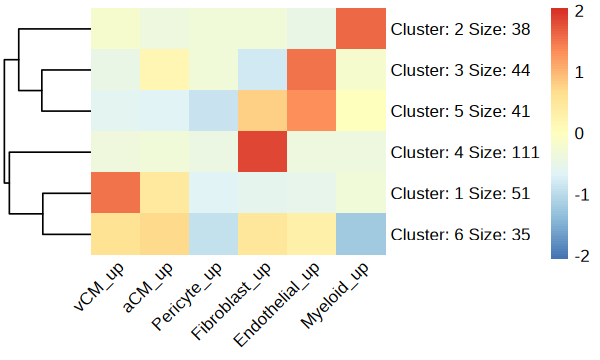

In [538]:
korder <- c("aCM","Endothelial","Fibroblast","Myeloid", "Pericyte","vCM")

motif <- list()
for (file in list.files("motif/", pattern  = paste0(korder, ".*_up", collapse = "|"))){
    motif[[file]] <- read.csv(paste0("motif/", file, "/knownResults.txt"), header = T, sep = "\t") %>%
    setNames(c("motif", "consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    mutate(cond = file)
}

vmotif <- do.call(rbind, motif) %>% group_by(motif) %>% 
filter(min(fdr) < 0.05) %>% ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique

motif <- do.call(rbind, motif) %>%
filter(motif %in% vmotif) %>%
reshape2::dcast(cond ~ motif, value.var = "p_value") %>%
tibble::column_to_rownames("cond") %>% t
motif[is.na(motif)] <- 1
motif <- -log2(motif)
motif[motif > 30] <- 30

options(repr.plot.width = 5, repr.plot.height = 3)
set.seed(921)
f1 <- motif[,paste0(c('vCM','aCM','Pericyte','Fibroblast','Endothelial','Myeloid'), "_up")] %>%
pheatmap(scale = "row", cluster_rows = T, 
         cluster_cols = F, border_color = NA, 
         kmeans_k = 6, show_rownames = T, angle_col = 45)

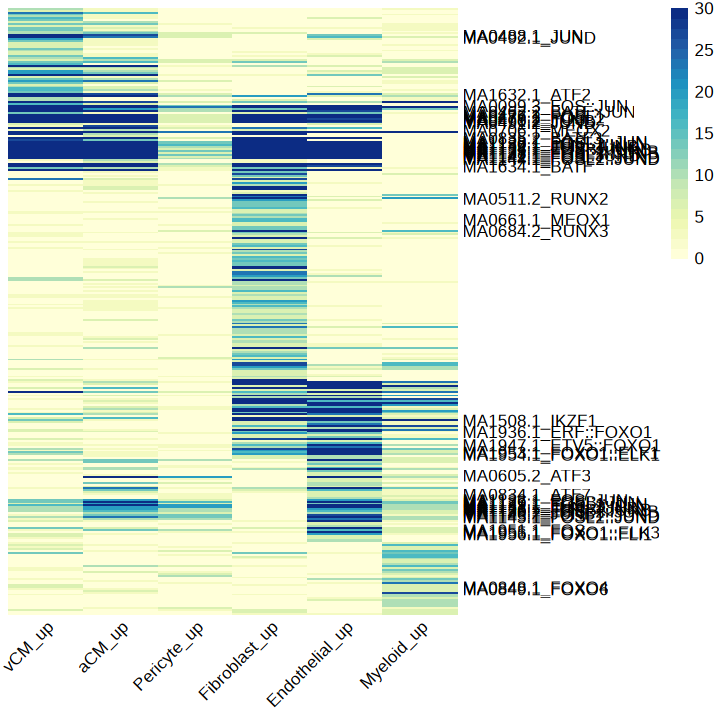

In [546]:
rorder <- f1$kmeans$cluster %>% as.data.frame %>% setNames("cluster") %>%
mutate(cluster = factor(cluster, levels = c(1,6,4,5,3,2))) %>% 
arrange(cluster)

mat1 <- motif[rownames(rorder),paste0(c('vCM','aCM','Pericyte','Fibroblast','Endothelial','Myeloid'), "_up")]
llabel <- c("ATF", "MEOX", 'RUNX', 'FOXO', 'IKZF1', 'FOS', 'JUN')
llabel <- grep(paste0(llabel, collapse = "|"), rownames(mat1), value = T)
labs.row <- rownames(mat1)
labs.row[!(labs.row %in% llabel)] <- ""

options(repr.plot.width = 6, repr.plot.height = 6)

t0 <- mat1 %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F, show_rownames = T, 
         angle_col = 45, labels_row = labs.row,
         border_color = NA, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

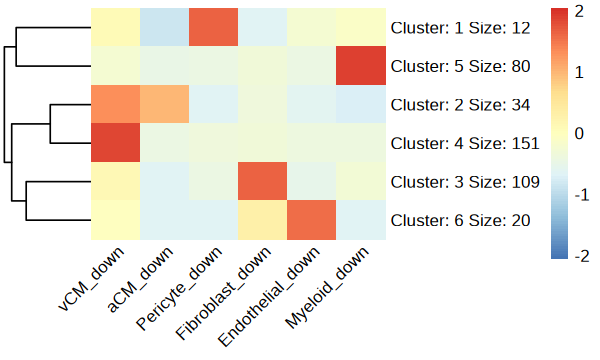

In [548]:
motif <- list()
for (file in list.files("motif/", pattern  = paste0(korder, ".*_down", collapse = "|"))){
    motif[[file]] <- read.csv(paste0("motif/", file, "/knownResults.txt"), header = T, sep = "\t") %>%
    setNames(c("motif", "consensus", "p_value", "log_p_value", "fdr", "tgt_num", "tgt_pct", "bgd_num", "bgd_pct")) %>%
    mutate(cond = file)
}

vmotif <- do.call(rbind, motif) %>% group_by(motif) %>% 
filter(min(fdr) < 0.05) %>% ungroup() %>%
dplyr::select(motif) %>% unlist %>% unique

motif <- do.call(rbind, motif) %>%
filter(motif %in% vmotif) %>%
reshape2::dcast(cond ~ motif, value.var = "p_value") %>%
tibble::column_to_rownames("cond") %>% t
motif[is.na(motif)] <- 1
motif <- -log2(motif)
motif[motif > 30] <- 30

set.seed(921)
options(repr.plot.width = 5, repr.plot.height = 3)
f2 <- motif[,paste0(c('vCM','aCM','Pericyte','Fibroblast','Endothelial','Myeloid'), "_down")] %>%
pheatmap(scale = "row", cluster_rows = T, 
         cluster_cols = F, border_color = NA, 
         kmeans_k = 6, show_rownames = T, angle_col = 45)

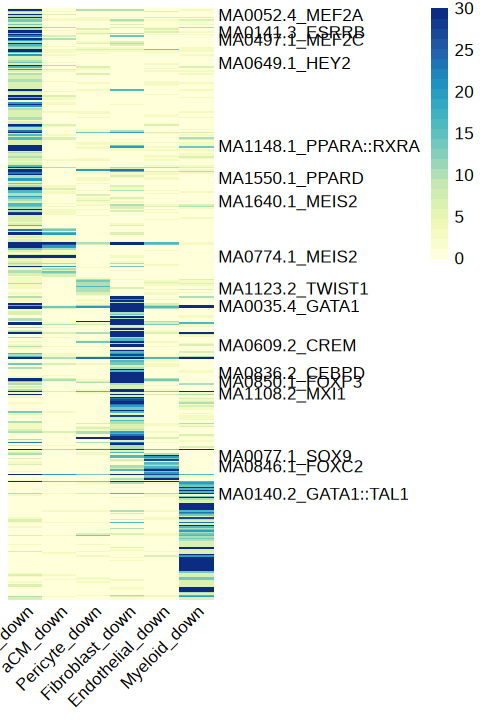

In [551]:
rorder <- f2$kmeans$cluster %>% as.data.frame %>% setNames("cluster") %>%
mutate(cluster = factor(cluster, levels = c(4,2,1,3,6,5))) %>% 
arrange(cluster)

options(repr.plot.width = 4, repr.plot.height = 6)
mat2 <- motif[rownames(rorder),paste0(c('vCM','aCM','Pericyte','Fibroblast','Endothelial','Myeloid'), "_down")]
llabel <- c('GATA1', 'FOXC2', 'SOX9', 'TWIST1','MXI1', 'FOXP3', 
            'CEBPD', 'CREM','PPARD', 'MEIS2', 'HEY2', 'MEF2C', 
            'ESRRB', 'NKX2−5', 'MEF2A', 'PPARA')
llabel <- grep(paste0(llabel, collapse = "|"), rownames(mat2), value = T)
labs.row <- rownames(mat2)
labs.row[!(labs.row %in% llabel)] <- ""

t0 <- mat2 %>%
pheatmap(scale = "none", cluster_rows = F, cluster_cols = F, 
         show_rownames = T, angle_col = 45, labels_row = labs.row,
         border_color = NA, 
         color = colorRampPalette(brewer.pal(n = 8, name = "YlGnBu"))(25))

ggsave(t0, filename = "plot/FIG_celltypes_depeaks_down_motif.pdf", dpi = 300, height = 6, width = 5)
write.table(mat2, "plot/FIG_celltypes_depeaks_down_motif.txt", sep = "\t", quote = F, row.names = T, col.names = T)

### Check shift in chromatin states

In [405]:
plist <- list()
for (f in setdiff(unique(atacde$celltype), "Lymphoid")){
    tde <- atacde %>% filter(celltype == f)
    qpeak <- sub("-", ":", tde[tde$log2FoldChange > 1,]$range)
    data <- chmm[qpeak, ] %>% count(across(everything()))
    t1 <- data %>%
    mutate(id = 1:nrow(.)) %>%
    tidyr::pivot_longer(cols = starts_with(f), names_to = "stage", values_to = "state") %>%
    mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
    ggplot(aes(x = stage, stratum = state, alluvium = id, y = n, fill = state)) +
    geom_flow() + ylab("Frequency") + 
    geom_stratum(color = "white") +
    theme_Publication() + ggtitle(paste0(f, ", log2FoldChange > 1")) + 
    NoLegend() + 
    scale_fill_manual(values = cols)

    qpeak <- sub("-", ":", tde[tde$log2FoldChange < -1,]$range)
    data <- chmm[qpeak, ] %>% count(across(everything()))
    t2 <- data %>%
    mutate(id = 1:nrow(.)) %>%
    tidyr::pivot_longer(cols = starts_with(f), names_to = "stage", values_to = "state") %>%
    mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
    ggplot(aes(x = stage, stratum = state, alluvium = id, y = n, fill = state)) +
    geom_flow() + ylab("Frequency") + 
    geom_stratum(color = "white") +
    theme_Publication() + ggtitle(paste0(f, ", log2FoldChange < -1")) + 
    NoLegend() + 
    scale_fill_manual(values = cols)
    
    plist[[f]] <- cowplot::plot_grid(t1, t2, ncol = 2)
}

fig1 <- cowplot::plot_grid(plotlist = plist, nrow = length(plist))

Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behav

In [474]:
# upregulation was associated with chromatin states switching from open to active 
### percentage of all shift (25 combination) for all DE peaks across all cell types
tde <- atacde %>% filter(celltype == f)
qpeak <- sub("-", ":", tde[tde$log2FoldChange > 0,]$range)
data <- chmm[qpeak, grep(f, colnames(chmm), value = T)] %>% count(across(everything()))
data %>%
mutate(id = 1:nrow(.)) %>%
tidyr::pivot_longer(cols = starts_with(f), names_to = "stage", values_to = "state") %>%
mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
dim

[1] 44  4

In [475]:
plist2 <- plist1 <- list()
for (f in setdiff(unique(atacde$celltype), "Lymphoid")){
    tde <- atacde %>% filter(celltype == f)
    qpeak <- sub("-", ":", tde[tde$log2FoldChange > 0,]$range)
    plist1[[f]] <- (100*table(chmm[qpeak, grep(f, colnames(chmm), value = T)])/length(qpeak)) %>%
    as.data.frame %>% setNames(c("CONTROL", "HF", "Freq")) %>% mutate(celltype = f)
    
    qpeak <- sub("-", ":", tde[tde$log2FoldChange < 0,]$range)
    plist2[[f]] <- (100*table(chmm[qpeak, grep(f, colnames(chmm), value = T)])/length(qpeak)) %>%
    as.data.frame %>% setNames(c("CONTROL", "HF", "Freq")) %>% mutate(celltype = f)
}

`summarise()` has grouped output by 'CONTROL'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”
`summarise()` has grouped output by 'CONTROL'. You can override using the `.groups` argument.
Warning message:
“`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`”


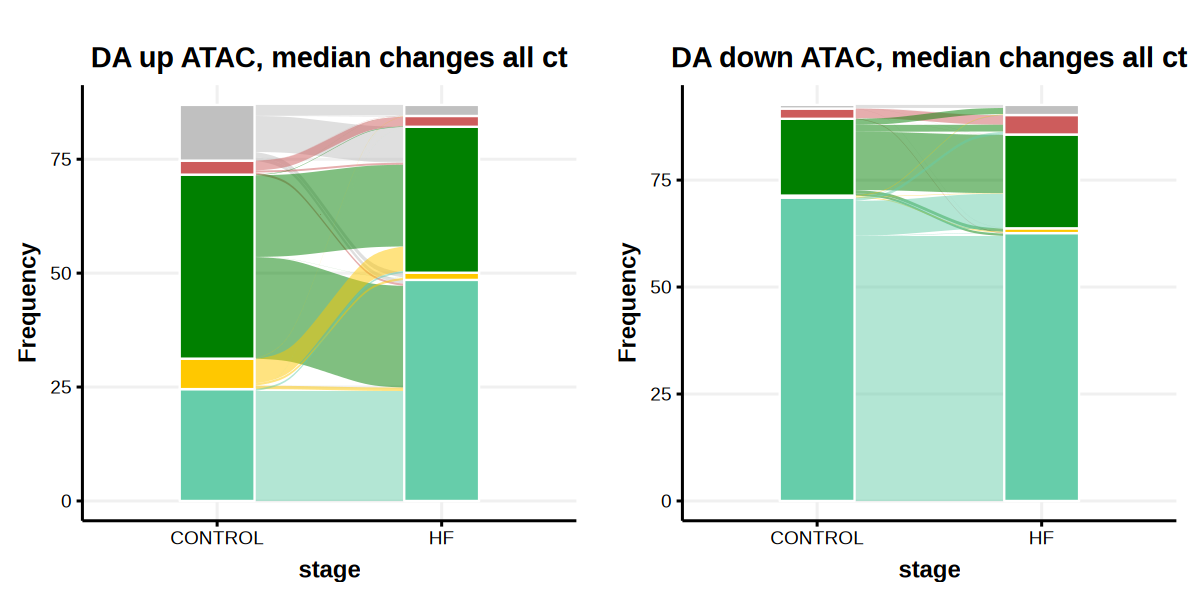

In [477]:
t1 <- do.call(rbind, plist1) %>%
group_by(CONTROL, HF) %>%
summarise(ratio = median(Freq)) %>%
ungroup %>%
count(across(everything())) %>%
mutate(id = 1:nrow(.)) %>%
tidyr::pivot_longer(cols = c(CONTROL, HF), names_to = "stage", values_to = "state") %>%
mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
ggplot(aes(x = stage, stratum = state, alluvium = id, y = ratio, fill = state)) +
geom_flow() + ylab("Frequency") + 
geom_stratum(color = "white") +
theme_Publication() + ggtitle("DA up ATAC, median changes all ct") + 
NoLegend() + 
scale_fill_manual(values = cols)

t2 <- do.call(rbind, plist2) %>%
group_by(CONTROL, HF) %>%
summarise(ratio = median(Freq)) %>%
ungroup %>%
count(across(everything())) %>%
mutate(id = 1:nrow(.)) %>%
tidyr::pivot_longer(cols = c(CONTROL, HF), names_to = "stage", values_to = "state") %>%
mutate(state = factor(state, levels = c("E2", "E1", "E3", "E4", "E5"))) %>%
ggplot(aes(x = stage, stratum = state, alluvium = id, y = ratio, fill = state)) +
geom_flow() + ylab("Frequency") + 
geom_stratum(color = "white") +
theme_Publication() + ggtitle("DA down ATAC, median changes all ct") + 
NoLegend() + 
scale_fill_manual(values = cols)

fig1 <- cowplot::plot_grid(t1, t2, ncol = 2)

fig1